<a href="https://colab.research.google.com/github/Agbomeji-Zainab/Forecasting-Unemployment-Rate-In-the-UK-A-hybrid-Approach/blob/main/Forecasting_Unemployment_Rate_in_the_UK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    { "figure.figsize": (6, 4) },
    style='ticks',
    color_codes=True,
    font_scale=0.8
)
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

import sklearn
sklearn.set_config(transform_output="pandas")

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform


Dataset

In [ ]:
data = pd.read_csv('/content/ONS DATASET.csv')
data

,Title,"Unemployment rate (aged 16 and over, seasonally adjusted): %"
0,CDID,MGSX
1,Source dataset ID,LMS
2,PreUnit,NaN
3,Unit,%
4,Release date,10-06-2025
...,...,...
923,2024 NOV,4.4
924,2024 DEC,4.4
925,2025 JAN,4.4
926,2025 FEB,4.5


The dataset contains multiple sections representing unemployment rates in different formats, including annual figures, quarterly figures, and monthly rates. However, this study focuses on forecasting using monthly unemployment rates, as they provide the necessary granularity for time-series models  and for generating lag-based features in machine learning models.

In [ ]:
#Extracting monthly unemployment rate
mdata = data.iloc[278:].reset_index(drop=True)

In [ ]:
mdata

,Title,"Unemployment rate (aged 16 and over, seasonally adjusted): %"
0,1971 FEB,3.8
1,1971 MAR,3.9
2,1971 APR,4.0
3,1971 MAY,4.1
4,1971 JUN,4.1
...,...,...
645,2024 NOV,4.4
646,2024 DEC,4.4
647,2025 JAN,4.4
648,2025 FEB,4.5


In [ ]:
#checking for null values
mdata.isnull().sum()

,0
Title,0
"Unemployment rate (aged 16 and over, seasonally adjusted): %",0


In [ ]:
#Rename columns
mdata = mdata[['Title', 'Unemployment rate (aged 16 and over, seasonally adjusted): %']]
mdata.columns = ['Date', 'Unemployment']

In [ ]:
#Converting the 'Date' column to datetime objects and set it as the index
mdata['Date'] = pd.to_datetime(mdata['Date'])
mdata = mdata.set_index('Date')
display(mdata.head())

,Unemployment
Date,
1971-02-01,3.8
1971-03-01,3.9
1971-04-01,4.0
1971-05-01,4.1
1971-06-01,4.1


In [ ]:
#Definning sub-periods
periods = {
    "Full Sample (1971-2025)": ("1971-01-01", "2025-12-31"),
    "Volatile Era (1971-1992)": ("1971-01-01", "1992-12-31"),
    "Great Moderation (1993-2008)": ("1993-01-01", "2008-12-31"),
    "Post-GFC Era (2009-2025)": ("2009-01-01", "2025-12-31")
}

#Function to calculate summary statistics
def compute_stats(series):
    # Convert series to numeric, coercing errors
    series = pd.to_numeric(series, errors='coerce')
    return {
        "N (Months)": series.count(),
        "Mean": series.mean(),
        "Median": series.median(),
        "Min": series.min(),
        "Max": series.max(),
        "Std Dev": series.std()
    }

#Building results
results = {}
for name, (start, end) in periods.items():
    # Filter the monthly data using the date index
    subset = mdata.loc[start:end, 'Unemployment']
    results[name] = compute_stats(subset)

#Converting to DataFrame for display
stats_df = pd.DataFrame(results).round(2)

stats_df

,Full Sample (1971-2025),Volatile Era (1971-1992),Great Moderation (1993-2008),Post-GFC Era (2009-2025)
N (Months),650.00,263.00,192.00,195.00
Mean,6.65,7.62,6.42,5.56
Median,5.65,7.20,5.50,4.90
Min,3.40,3.40,4.70,3.60
Max,11.90,11.90,10.70,8.50
Std Dev,2.38,2.82,1.75,1.64


In [ ]:
#Discriptive statistics
print(mdata['Unemployment'].describe())

count     650
unique     86
top       5.5
freq       30
Name: Unemployment, dtype: object


In [ ]:
#Checking for skewness
mdata['Unemployment'].skew()

np.float64(0.6868351880392183)

States that unemployment data is moderately positively skewed (Skew > 0.5).

# Graphical Representation of Monthly UK Unemployment Rate (1971 Feb –2025 Mar)



In [ ]:
#Convert Unemployment to numeric (in case it's stored as string)
mdata['Unemployment'] = pd.to_numeric(mdata['Unemployment'], errors='coerce')

In [ ]:
import plotly.express as px

#Ensure 'Year' column exists for coloring
mdata['Year'] = mdata.index.year.astype(str)

# Plot
fig = px.line(
    mdata,
    x=mdata.index,
    y='Unemployment',
    color='Year',
    title='Monthly UK Unemployment Rate (1971 FEB–2025 MAR)',
    labels={'Unemployment': 'Unemployment Rate (%)', 'Date': 'Date'},
    template='plotly_white'
)

fig.update_layout(width=1200, height=500)
fig.show()


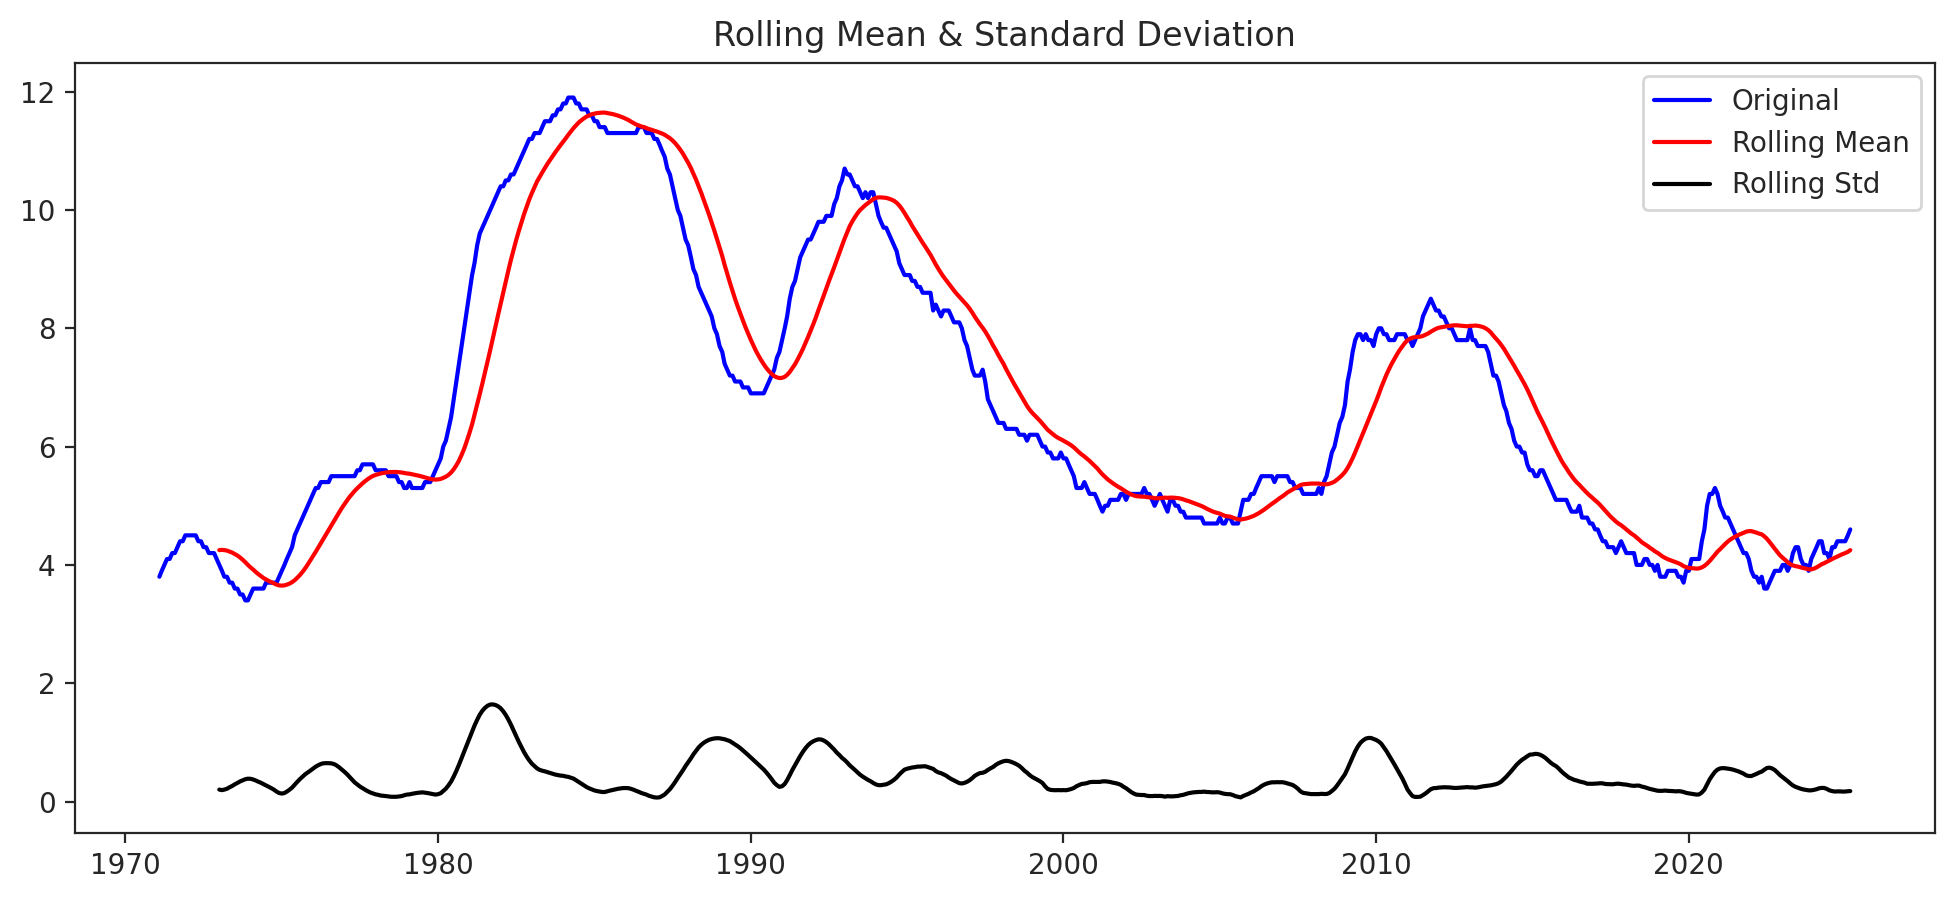

In [ ]:
#Rolling statistic
roll_mean = mdata['Unemployment'].rolling(window=24).mean()
roll_std = mdata['Unemployment'].rolling(window=24).std()

#Plot
plt.figure(figsize=(12, 5))
plt.plot(mdata['Unemployment'], label='Original', color='blue')
plt.plot(roll_mean, label='Rolling Mean', color='red')
plt.plot(roll_std, label='Rolling Std', color='black')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

Check for stationarity (ADF (Augmented Dickey-Fuller) test): This test checks if your unemployment series is stationary

In [ ]:
from statsmodels.tsa.stattools import adfuller

#Perform the ADF test on the 'Unemployment' column of the mdata DataFrame
adf_test = adfuller(mdata['Unemployment'])

# Extract and print the results
adf_statistic = adf_test[0]
p_value = adf_test[1]
critical_values = adf_test[4]

print(f'ADF Statistic: {adf_statistic}')
print(f'P-value: {p_value}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'  {key}: {value}')

# Interpret the results
if p_value <= 0.05:
    print("Result: The time series is likely stationary (reject the null hypothesis).")
else:
    print("Result: The time series is likely non-stationary (fail to reject the null hypothesis).")

ADF Statistic: -2.101842679200201
P-value: 0.24377429679726859
Critical Values:
  1%: -3.44065745275905
  5%: -2.8660879520543534
  10%: -2.5691919933016076
Result: The time series is likely non-stationary (fail to reject the null hypothesis).


Since p-value = 0.2438 > 0.05, this implies that the time series is not stationary. which means: It still contains trends or patterns over time and ARIMA cannot model it correctly in its current form

What To Do Next: Apply First-order Differencing

Starts by transforming the data by subtracting the previous value from each one , this is called first differencing.

# First-Order Differencing


In [ ]:
mdata_diff = mdata['Unemployment'].diff().dropna()

 Plot to Visually Inspect:

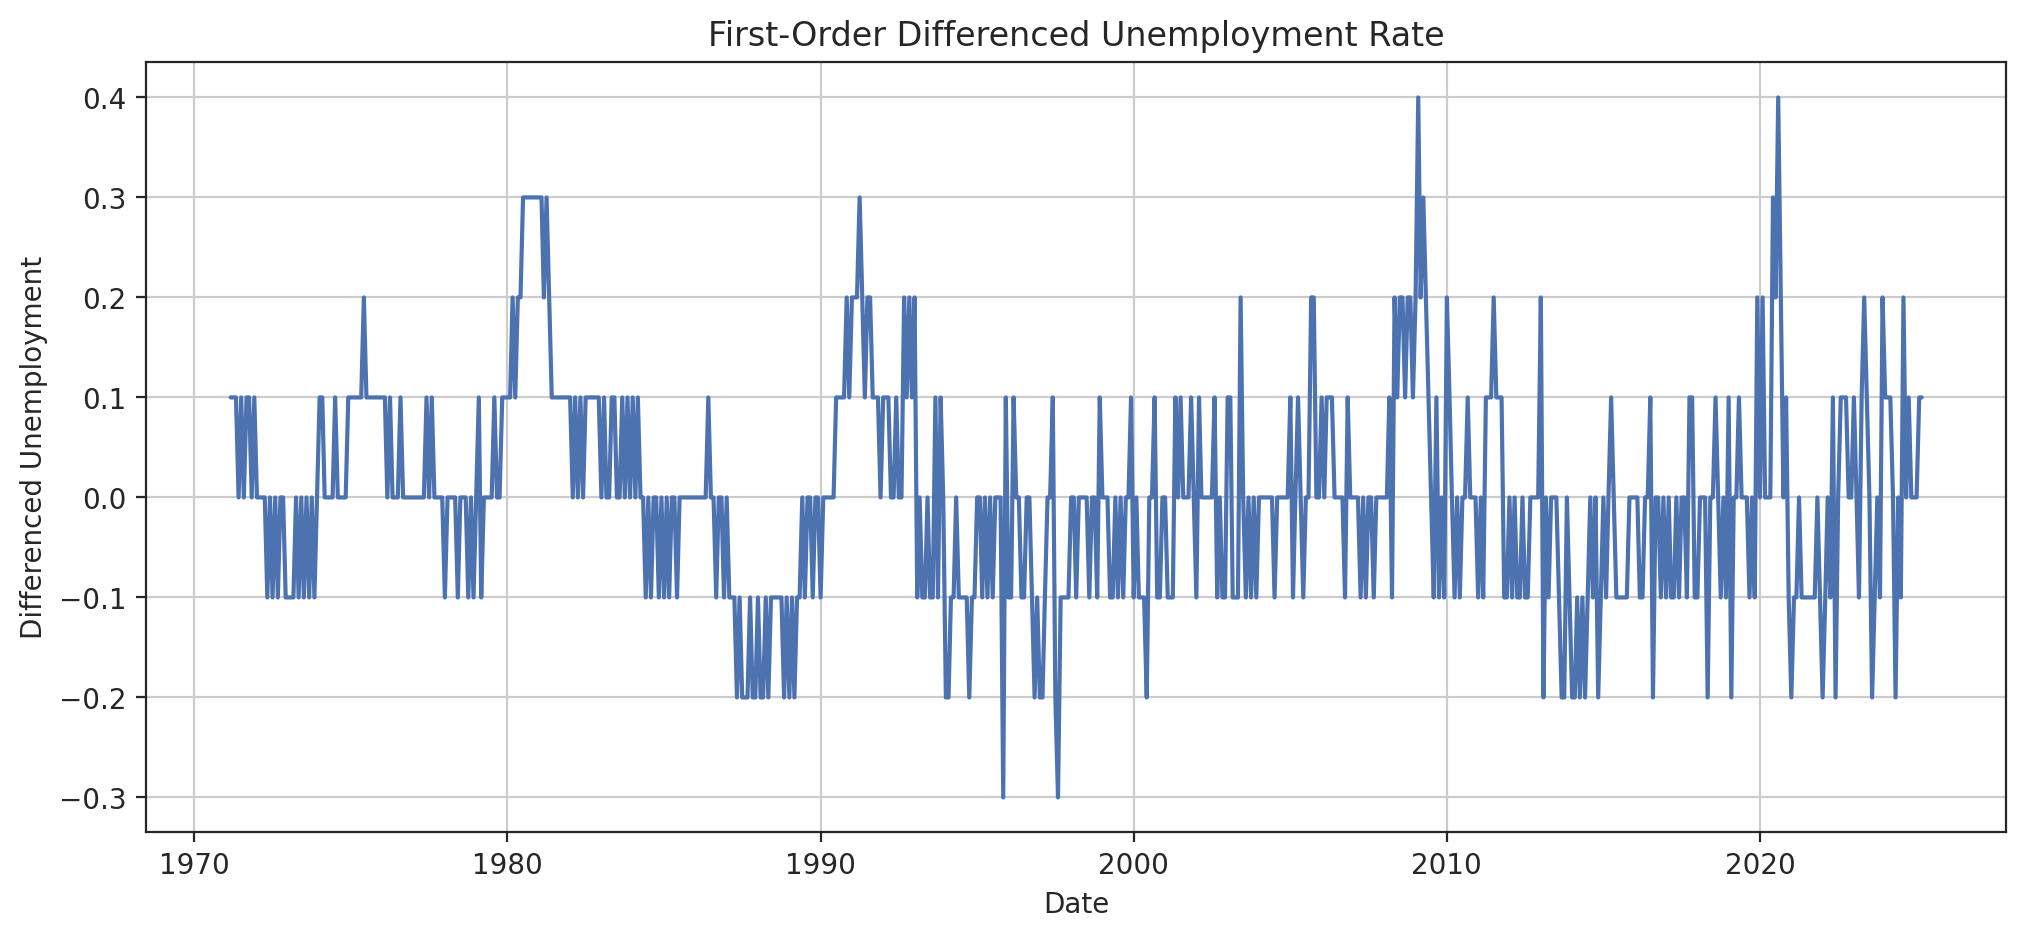

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(mdata_diff)
plt.title('First-Order Differenced Unemployment Rate')
plt.xlabel('Date')
plt.ylabel('Differenced Unemployment')
plt.grid(True)
plt.show()

Run ADF Test Again on Differenced Series

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_test_diff = adfuller(mdata_diff)
print(f"ADF Statistic: {adf_test_diff[0]}")
print(f"P-value: {adf_test_diff[1]}")
print('Critical Values:')
for key, value in adf_test_diff[4].items():
    print(f'  {key}: {value}')
if adf_test_diff[1] <= 0.05:
    print("The differenced series is likely stationary.")
else:
    print("Still non-stationary. You may need second-order differencing.")

ADF Statistic: -4.9690409673730525
P-value: 2.5546743028137403e-05
Critical Values:
  1%: -3.44065745275905
  5%: -2.8660879520543534
  10%: -2.5691919933016076
The differenced series is likely stationary.


Now p-value is < 0.05 which mean it is very stationary

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_test_diff = adfuller(mdata_diff)
print(f"ADF Statistic: {adf_test_diff[0]}")
print(f"P-value: {adf_test_diff[1]}")
if adf_test_diff[1] <= 0.05:
    print("The differenced series is likely stationary.")
else:
    print("Still non-stationary. You may need second-order differencing.")


ADF Statistic: -4.9690409673730525
P-value: 2.5546743028137403e-05
The differenced series is likely stationary.


# ACF and PACF PLOT

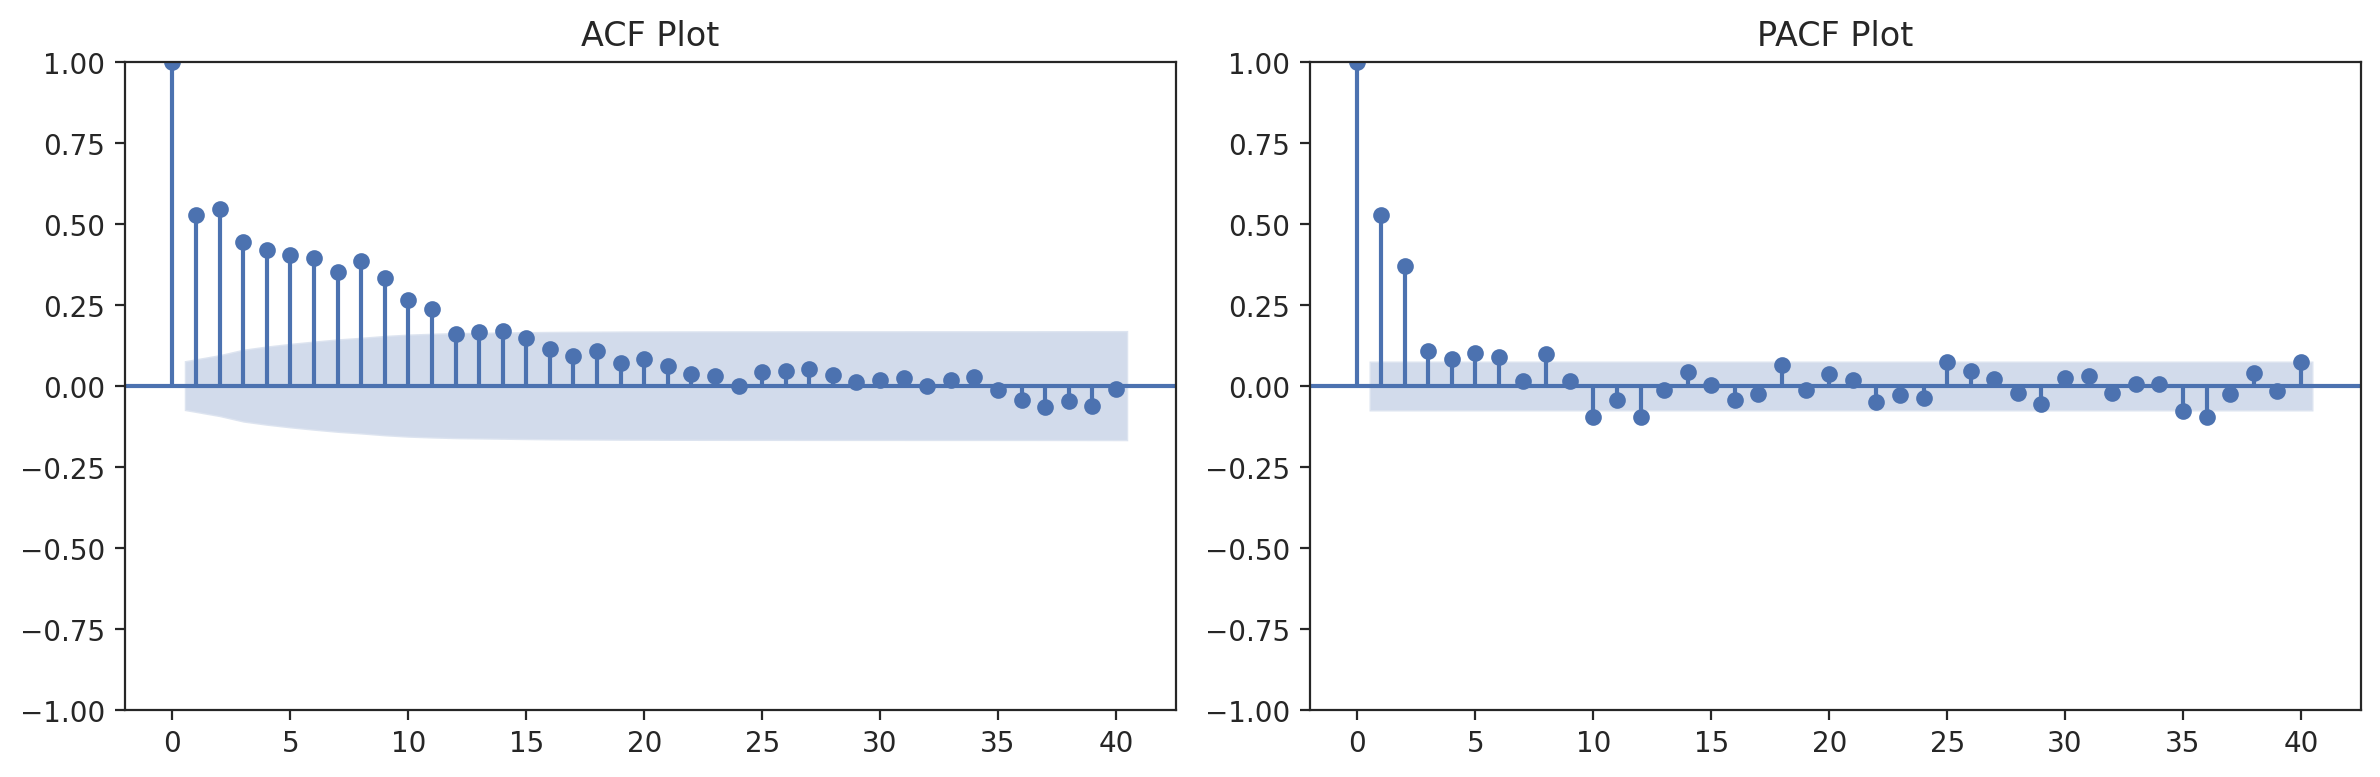

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# First-order differenced series
diff_series = mdata['Unemployment'].diff().dropna()

#Plot ACF and PACF
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plot_acf(diff_series, lags=40, ax=plt.gca(), title='ACF Plot')

plt.subplot(1, 2, 2)
plot_pacf(diff_series, lags=40, ax=plt.gca(), title='PACF Plot', method='ywm')

plt.tight_layout()
plt.show()

The PACF plot shows a sharp cut-off at lag 1 (suggesting p=1), while the ACF plot decays slowly, which is consistent with an AR(1) process (suggesting q=0).

At the seasonal lags, the PACF again cuts off at lag 12 (P=1), and the slow decay in the ACF suggests seasonal differencing is also needed (D=1).

This analysis points to an initial model of SARIMA(1, 1, 0)(1, 1, 0, 12). This will be used as a starting point and refined using information criteria like AIC.

## Fitting SARIMA(1, 1, 0)(1, 1, 0, 12)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit the SARIMA(1, 1, 0)(1, 1, 0, 12) model
model = SARIMAX(mdata['Unemployment'], order=(1, 1, 0), seasonal_order=(1, 1, 0, 12))
results = model.fit()

# Print the model summary
print(results.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                                     SARIMAX Results                                      
Dep. Variable:                       Unemployment   No. Observations:                  650
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                 480.979
Date:                            Fri, 12 Sep 2025   AIC                           -955.959
Time:                                    15:06:39   BIC                           -942.588
Sample:                                02-01-1971   HQIC                          -950.768
                                     - 03-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4614      0.034     13.536      0.000       0.395       0.528
ar.S.L12      -0.4724      0.033   

This model, SARIMA(1, 1, 0)(1, 1, 0, 12), is a decent first attempt, but the diagnostic tests show it is not yet a good final model.

## Fitting Alternative model SARIMA(2, 1, 1)(2, 1, 1, 12)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Fit the SARIMA(2, 1, 1)(2, 1, 1, 12) model
model2 = SARIMAX(mdata['Unemployment'], order=(2, 1, 1), seasonal_order=(2, 1, 1, 12))
results2 = model2.fit()

# Print the model summary
print(results2.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                     SARIMAX Results                                      
Dep. Variable:                       Unemployment   No. Observations:                  650
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood                 655.636
Date:                            Fri, 12 Sep 2025   AIC                          -1297.271
Time:                                    15:07:05   BIC                          -1266.074
Sample:                                02-01-1971   HQIC                         -1285.159
                                     - 03-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8369      0.066     12.630      0.000       0.707       0.967
ar.L2          0.0969      0.054   

Based on information criteria and residual diagnostics, the SARIMA(2,1,1)(2,1,1,12) model offers a significantly improved fit over the simpler SARIMA(1,1,0)(1,1,0,12) model. The AIC dropped from -955.96 to -1297.271, and all coefficients were statistically significant. This model successfully captured both short-term and seasonal dynamics in the UK unemployment rate, despite minor signs of non-normality and heteroskedasticity in the residuals.

## Split the Dataset into Train and Test Sets

In [ ]:
#Train until Dec 2022, test from Jan 2023 to Mar 2025
train_sarima = mdata[:'2022-12-01']
test_sarima = mdata['2023-01-01':]

#Set frequency to Monthly Start to remove warning
train_sarima = train_sarima.asfreq('MS')
test_sarima = test_sarima.asfreq('MS')

Fit SARIMA(2,1,1)(2,1,1,12) on the Training Set

In [ ]:
#Fit the model on training data
model_sarima = SARIMAX(train_sarima['Unemployment'], order=(2,1,1), seasonal_order=(2,1,1,12))
results_sarima = model_sarima.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Generate Forecast for the Test Set


In [ ]:
#Forecast the next steps equal to the length of the test set
forecast_sarima = results_sarima.get_forecast(steps=len(test_sarima))
predicted_sarima = forecast_sarima.predicted_mean

Evaluate the Forecast Accuracy

In [ ]:
#Evaluation metrics
rmse_sarima = np.sqrt(mean_squared_error(test_sarima['Unemployment'], predicted_sarima))
mae_sarima = mean_absolute_error(test_sarima['Unemployment'], predicted_sarima)
mape_sarima = mean_absolute_percentage_error(test_sarima['Unemployment'], predicted_sarima) * 100

# Print results
print(f'RMSE: {rmse_sarima:.4f}')
print(f'MAE: {mae_sarima:.4f}')
print(f'MAPE: {mape_sarima:.2f}%')

RMSE: 0.1490
MAE: 0.1229
MAPE: 2.89%


# Residual

In [ ]:
#Getting residuals from the fitted model
residuals = results_sarima.resid

print("=== SARIMA(2,1,1)(2,1,1,12) DIAGNOSTIC TESTS ===")
print("=" * 55)

#LJUNG-BOX TEST (Testing for autocorrelation in residuals)
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(residuals, lags=10, return_df=True)
print("1. LJUNG-BOX TEST (p-values should be > 0.05):")
print(lb_test)
print()

#JARQUE-BERA TEST (Testing for normality)
from statsmodels.stats.stattools import jarque_bera
jb_stat, jb_pvalue, _, _ = jarque_bera(residuals)
print(f"2. JARQUE-BERA NORMALITY TEST:")
print(f"   Statistic: {jb_stat:.4f}, p-value: {jb_pvalue:.4f}")
print(f"   Result: {' Normal' if jb_pvalue > 0.05 else ' Non-normal'} residuals")
print()

#PARAMETER SIGNIFICANCE
print("3. PARAMETER SIGNIFICANCE (p-values should be < 0.05):")
for param, pvalue in results_sarima.pvalues.items():
    significance = " Significant" if pvalue < 0.05 else " Not significant"
    print(f"   {param}: p-value = {pvalue:.6f} ({significance})")
print()

#MODEL FIT STATISTICS
print("4. MODEL FIT STATISTICS:")
print(f"   AIC: {results_sarima.aic:.2f}")
print(f"   BIC: {results_sarima.bic:.2f}")
print(f"   Log Likelihood: {results_sarima.llf:.2f}")
print()

=== SARIMA(2,1,1)(2,1,1,12) DIAGNOSTIC TESTS ===
1. LJUNG-BOX TEST (p-values should be > 0.05):
     lb_stat  lb_pvalue
1   0.473057   0.491584
2   0.774479   0.678928
3   1.027353   0.794634
4   1.334532   0.855490
5   1.560355   0.906002
6   1.560577   0.955370
7   1.734312   0.973074
8   2.472958   0.962980
9   2.475159   0.981544
10  2.799345   0.985760

2. JARQUE-BERA NORMALITY TEST:
   Statistic: 1928234.8151, p-value: 0.0000
   Result:  Non-normal residuals

3. PARAMETER SIGNIFICANCE (p-values should be < 0.05):
   ar.L1: p-value = 0.000000 ( Significant)
   ar.L2: p-value = 0.007362 ( Significant)
   ma.L1: p-value = 0.000000 ( Significant)
   ar.S.L12: p-value = 0.040002 ( Significant)
   ar.S.L24: p-value = 0.047306 ( Significant)
   ma.S.L12: p-value = 0.000000 ( Significant)
   sigma2: p-value = 0.000000 ( Significant)

4. MODEL FIT STATISTICS:
   AIC: -1265.35
   BIC: -1234.45
   Log Likelihood: 639.67



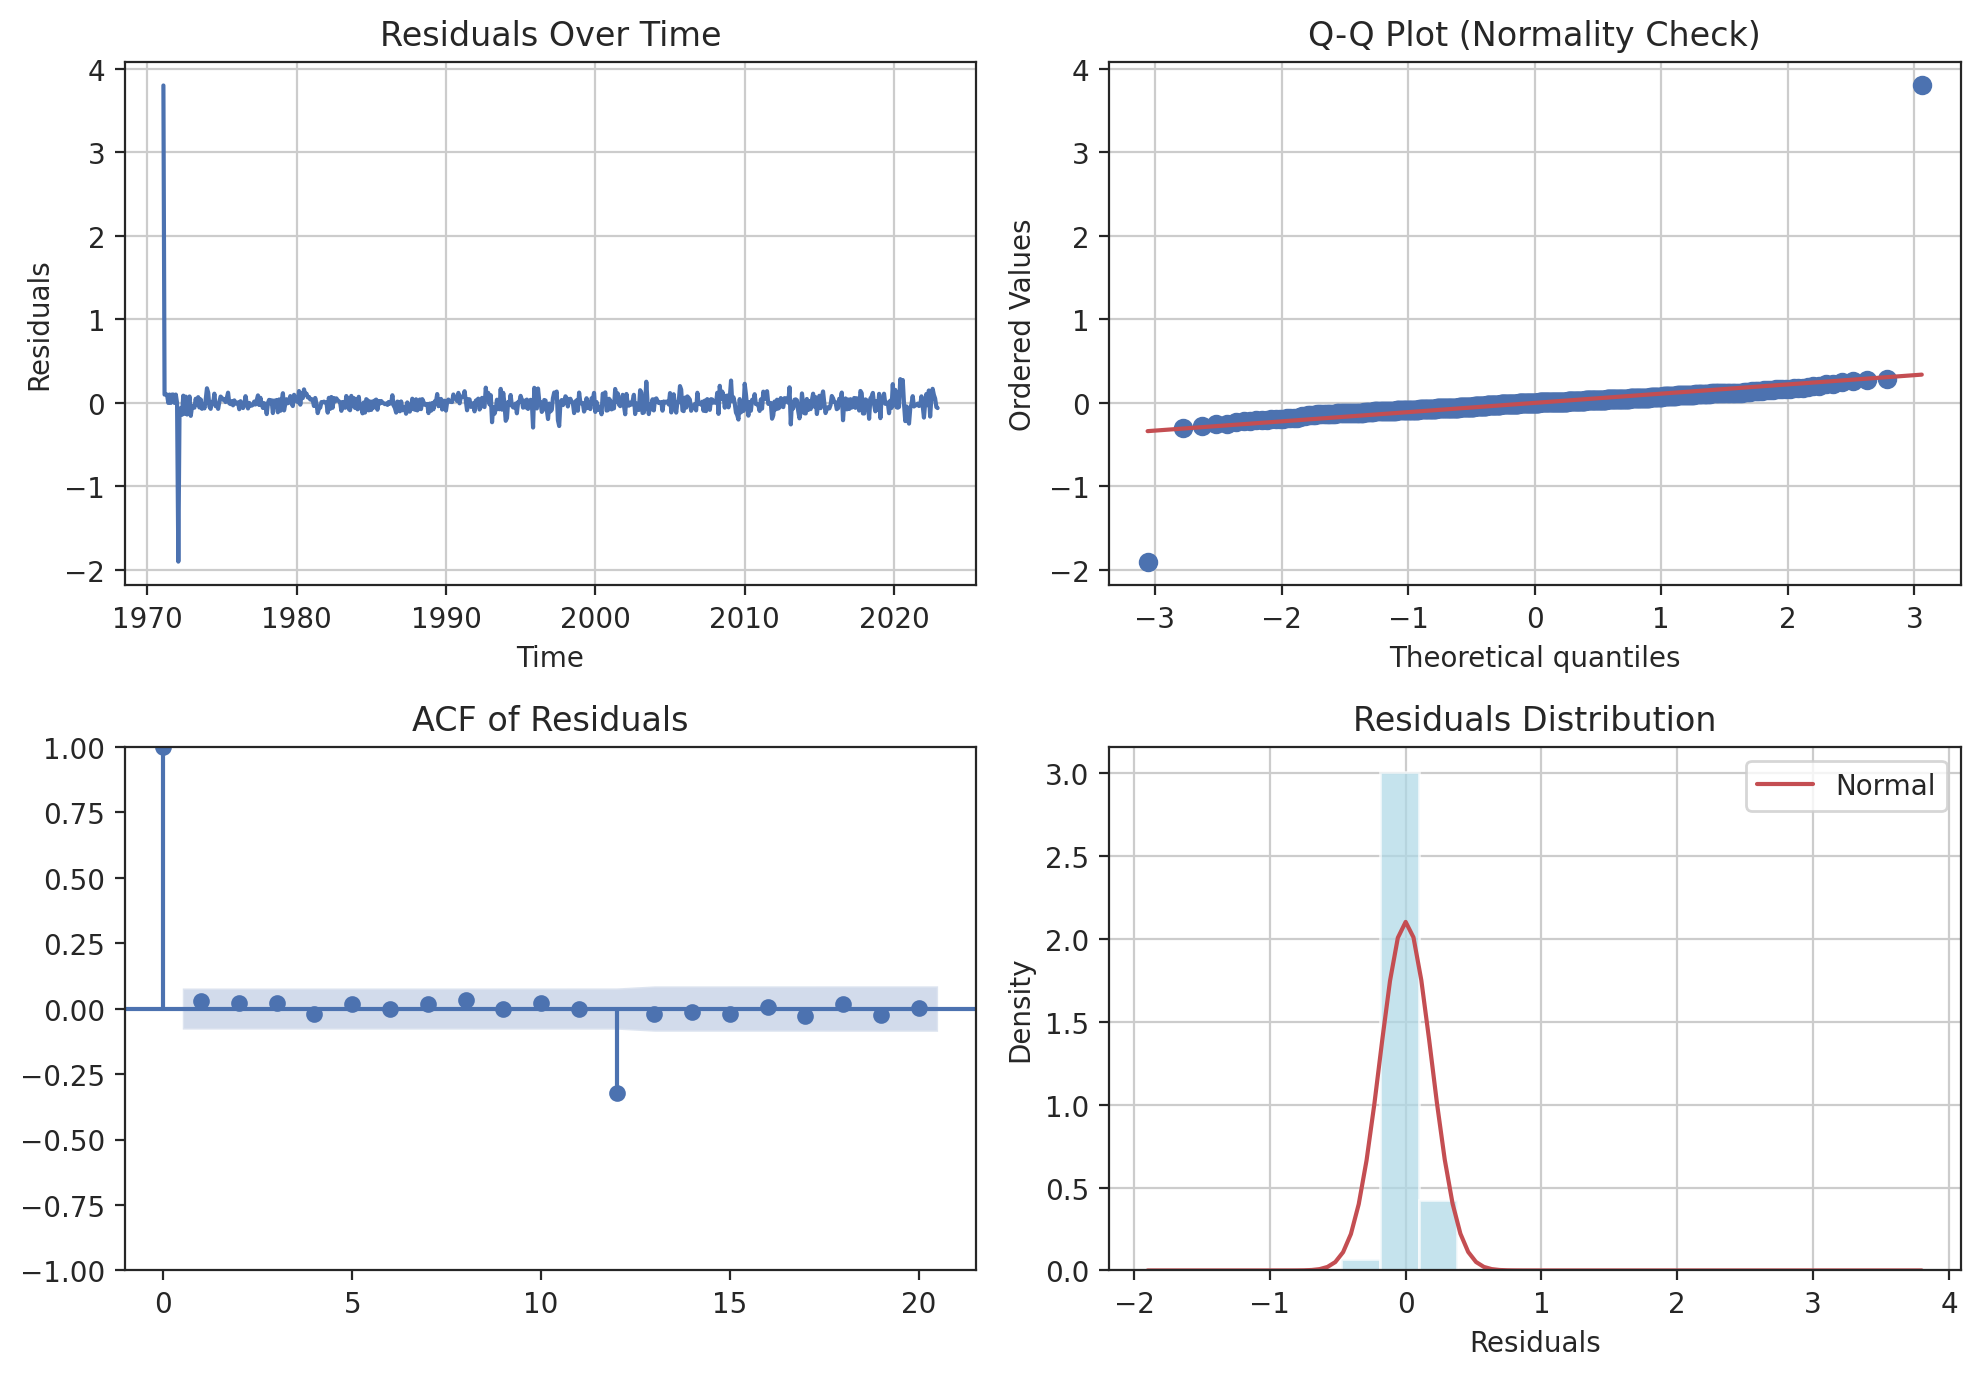

In [ ]:
#VISUAL DIAGNOSTICS
fig, axes = plt.subplots(2, 2, figsize=(10, 7))

#Residuals plot
axes[0,0].plot(residuals)
axes[0,0].set_title('Residuals Over Time')
axes[0,0].set_xlabel('Time')
axes[0,0].set_ylabel('Residuals')
axes[0,0].grid(True)

#Q-Q plot for normality
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[0,1])
axes[0,1].set_title('Q-Q Plot (Normality Check)')
axes[0,1].grid(True)

#ACF of residuals
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, ax=axes[1,0], lags=20, alpha=0.05)
axes[1,0].set_title('ACF of Residuals')

#Histogram of residuals
axes[1,1].hist(residuals, bins=20, density=True, alpha=0.7, color='lightblue')
axes[1,1].set_title('Residuals Distribution')
axes[1,1].set_xlabel('Residuals')
axes[1,1].set_ylabel('Density')
axes[1,1].grid(True)

#Add normal curve overlay
x = np.linspace(residuals.min(), residuals.max(), 100)
axes[1,1].plot(x, stats.norm.pdf(x, residuals.mean(), residuals.std()), 'r-', label='Normal')
axes[1,1].legend()

plt.tight_layout()
plt.show()


In [ ]:
#SUMMARY
print("6. DIAGNOSTIC SUMMARY:")
print("-" * 25)
ljung_box_ok = all(lb_test['lb_pvalue'] > 0.05)
normality_ok = jb_pvalue > 0.05
params_significant = all(results_sarima.pvalues < 0.05)

print(f"    No autocorrelation: {ljung_box_ok}")
print(f"   {'' if normality_ok else ''} Normal residuals: {normality_ok}")
print(f"   {'' if params_significant else ''} All parameters significant: {params_significant}")

if ljung_box_ok and params_significant:
    print(f"\n OVERALL: SARIMA(2,1,1)(2,1,1,12) model passes key diagnostic tests!")
else:
    print(f"\n OVERALL: Some diagnostic concerns, but model may still be usable.")

6. DIAGNOSTIC SUMMARY:
-------------------------
    No autocorrelation: True
    Normal residuals: False
    All parameters significant: True

 OVERALL: SARIMA(2,1,1)(2,1,1,12) model passes key diagnostic tests!


Plot Actual vs Predicted for Test Period

Refit SARIMA on Full Data and Forecast to 2030

In [ ]:
mdata = mdata.asfreq('MS')  #Set frequency for full dataset

#Fitting model on full data
final_model = SARIMAX(mdata['Unemployment'], order=(2,1,1), seasonal_order=(2,1,1,12))
final_result = final_model.fit()

#Creating future dates to forecast to December 2030
future_index = pd.date_range(start=mdata.index[-1] + pd.DateOffset(months=1), end='2030-12-01', freq='MS')

#Generating forecast
future_forecast = final_result.get_forecast(steps=len(future_index))
future_pred = future_forecast.predicted_mean
future_ci = future_forecast.conf_int()

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Plot Future Forecast to 2030

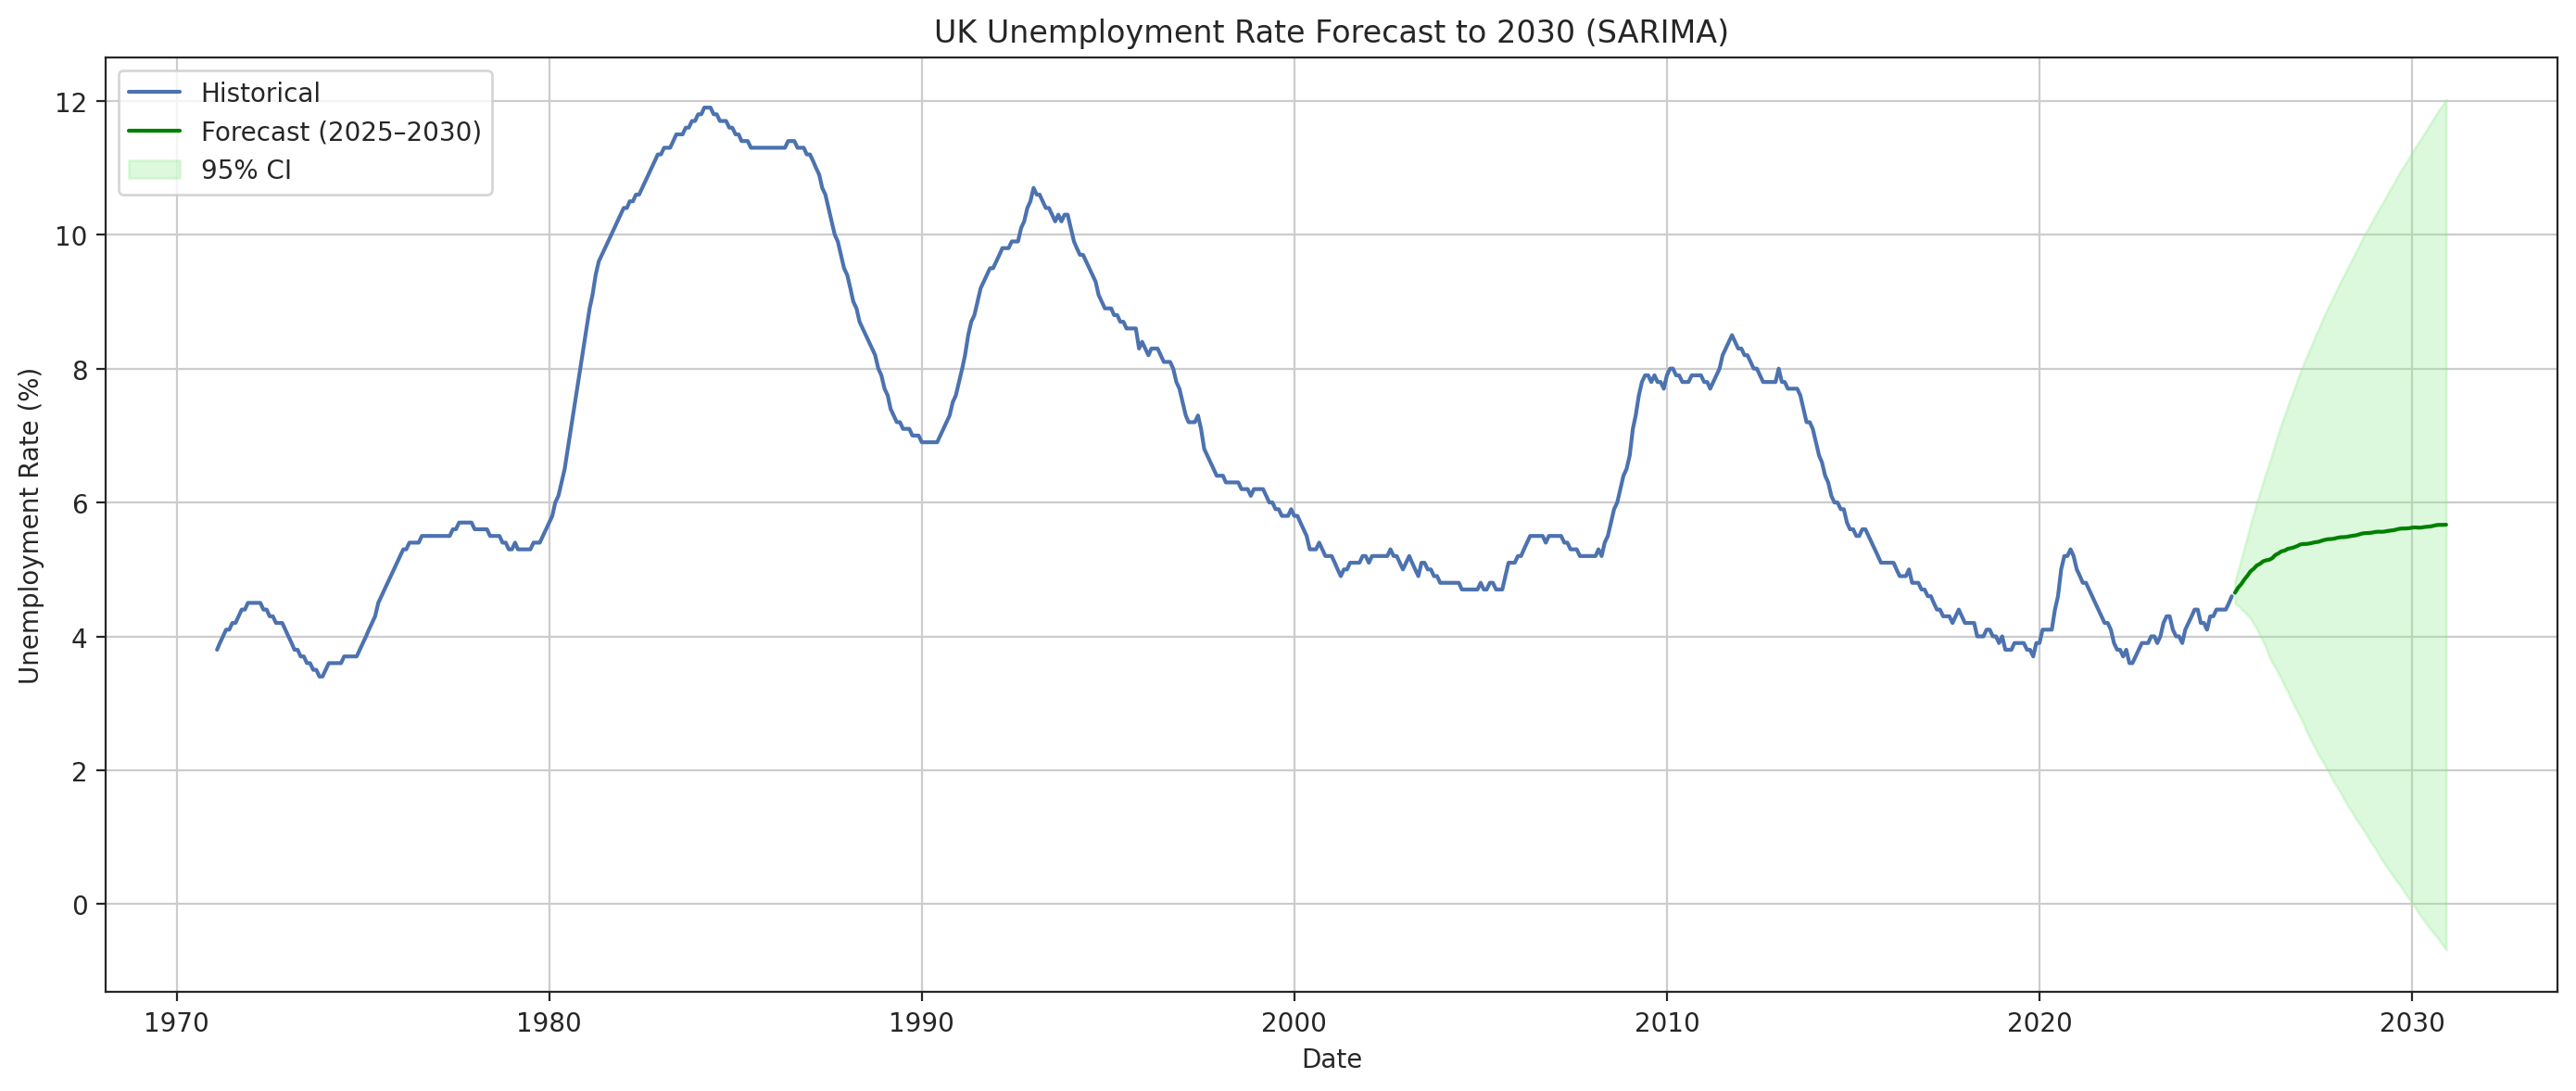

In [ ]:
#Plot future forecast
plt.figure(figsize=(14, 6))
plt.plot(mdata.index, mdata['Unemployment'], label='Historical')
plt.plot(future_index, future_pred, label='Forecast (2025–2030)', color='green')
plt.fill_between(future_index, future_ci.iloc[:, 0], future_ci.iloc[:, 1], color='lightgreen', alpha=0.3, label='95% CI')
plt.title('UK Unemployment Rate Forecast to 2030 (SARIMA)')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Machine Learning Prediction

In [ ]:
#Create lag and rolling features
mdata['Lag_1'] = mdata['Unemployment'].shift(1)
mdata['Lag_3'] = mdata['Unemployment'].shift(3)
mdata['Lag_6'] = mdata['Unemployment'].shift(6)
mdata['Lag_12'] = mdata['Unemployment'].shift(12)

mdata['Rolling_Mean_12'] = mdata['Unemployment'].rolling(window=12).mean()
mdata['Rolling_Std_12'] = mdata['Unemployment'].rolling(window=12).std()

#Drop rows with missing values due to lagging
ml_data = mdata.dropna()


In [ ]:
#Split into train/test for ML model
train_ml = ml_data.loc[:'2022-12-01']
test_ml = ml_data.loc['2023-01-01':]

#Define features and target
features = ['Lag_1', 'Lag_3', 'Lag_6', 'Lag_12', 'Rolling_Mean_12', 'Rolling_Std_12']
X_train = train_ml[features]
y_train = train_ml['Unemployment']

X_test = test_ml[features]
y_test = test_ml['Unemployment']


## Random Forest

Train Random Forest Regressor

In [ ]:
#Train the model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

#Predict on test set
rf_pred = rf_model.predict(X_test)

Evaluate Random Forest alone (standalone ML model)

In [ ]:
#Evaluate Random Forest alone (standalone ML model)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_mape = mean_absolute_percentage_error(y_test, rf_pred) * 100

print(f"Random Forest Only - RMSE: {rf_rmse:.4f}")
print(f"Random Forest Only - MAE: {rf_mae:.4f}")
print(f"Random Forest Only - MAPE: {rf_mape:.2f}%")

Random Forest Only - RMSE: 0.1291
Random Forest Only - MAE: 0.1044
Random Forest Only - MAPE: 2.48%


Create Hybrid (SARIMA + Random Forest)

In [ ]:
#Combine SARIMA + GB with equal weights
rf_hybrid = 0.5 * predicted_sarima.values + 0.5 * rf_pred

In [ ]:
#Evaluate Hybrid Model
rmse_rh = np.sqrt(mean_squared_error(y_test, rf_hybrid))
mae_rh  = mean_absolute_error(y_test, rf_hybrid)
mape_rh = mean_absolute_percentage_error(y_test, rf_hybrid) * 100

print(f"Hybrid: SARIMA + RF - RMSE: {rmse_rh:.4f}")
print(f"Hybrid: SARIMA + RF - MAE: {mae_rh:.4f}")
print(f"Hybrid: SARIMA + RF - MAPE: {mape_rh:.2f}%")

Hybrid: SARIMA + RF - RMSE: 0.1161
Hybrid: SARIMA + RF - MAE: 0.0970
Hybrid: SARIMA + RF - MAPE: 2.29%


Plot: SARIMA + Random Forest Hybrid Forecast

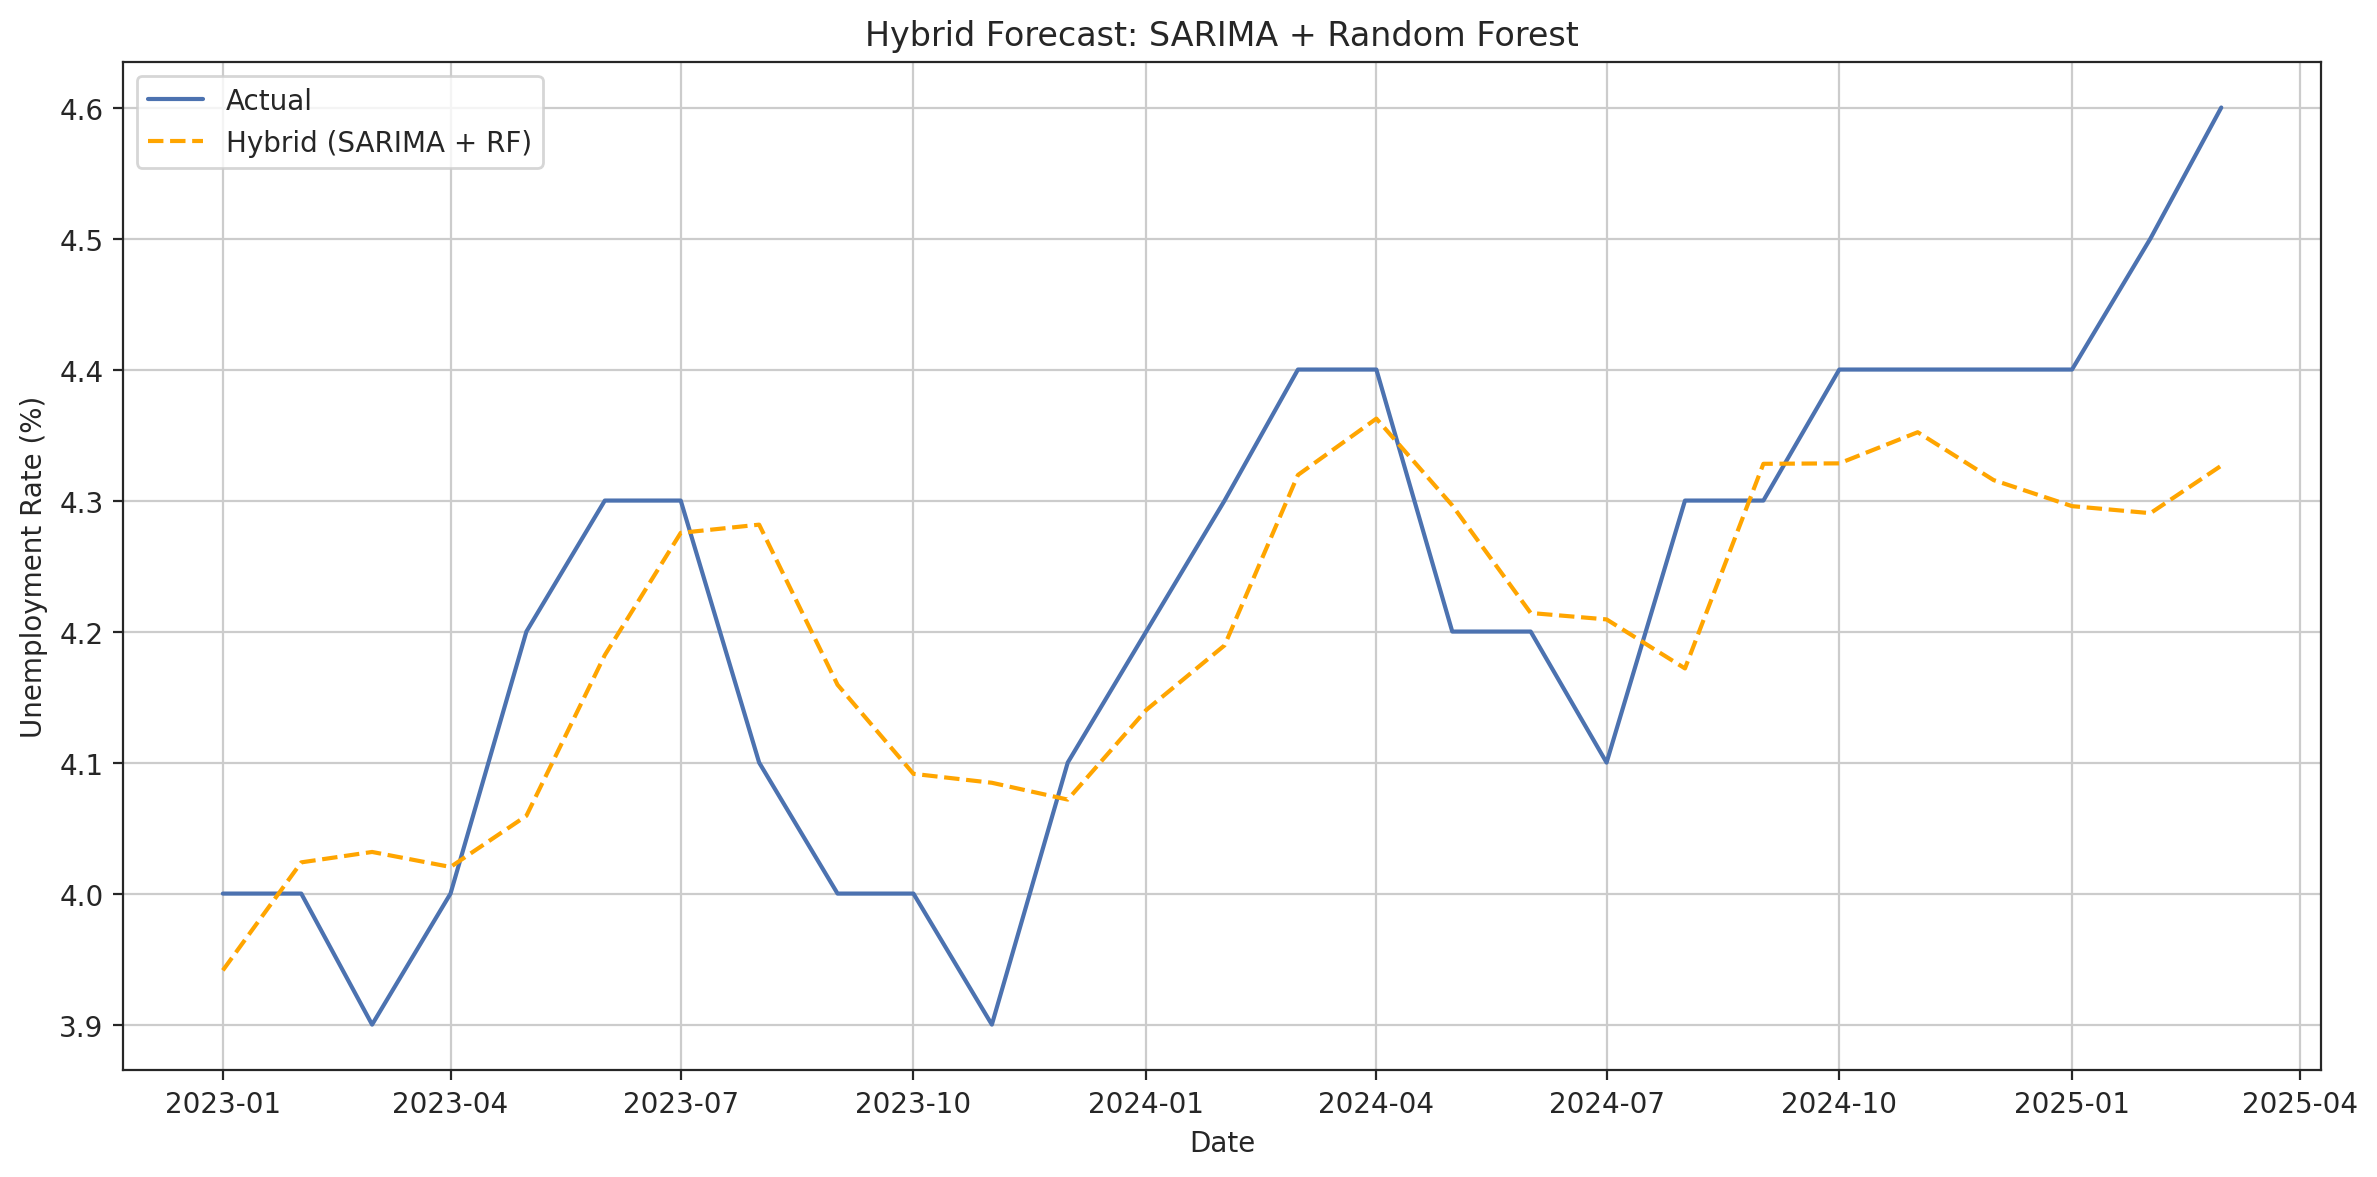

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, rf_hybrid, label='Hybrid (SARIMA + RF)', linestyle='--', color='orange')
plt.title('Hybrid Forecast: SARIMA + Random Forest')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Random Forest Hyper Parameter tunning

In [ ]:
#Define Random Forest
rf = RandomForestRegressor(random_state=42)

#Define parameter distributions for random search
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [10, 20, None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2']
}

In [ ]:
#Randomized search setup
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

In [ ]:
#Fit the random search model
random_search.fit(X_train, y_train)

#Best parameters and model
print("Best Parameters:", random_search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 445}


In [ ]:
best_trf = random_search.best_estimator_

#Predict with tuned Random Forest
trf_pred = best_trf.predict(X_test)


Evaluate Tuned Random Forest  (standalone Tuned ML model)

In [ ]:
#Evaluate tuned model
trf_rmse = np.sqrt(mean_squared_error(y_test, trf_pred))
trf_mae = mean_absolute_error(y_test, trf_pred)
trf_mape = mean_absolute_percentage_error(y_test, trf_pred) * 100

print(f"Tuned RF - RMSE: {trf_rmse:.4f}")
print(f"Tuned RF - MAE: {trf_mae:.4f}")
print(f"Tuned RF - MAPE: {trf_mape:.4f}%")

Tuned RF - RMSE: 0.1372
Tuned RF - MAE: 0.1134
Tuned RF - MAPE: 2.6979%


Create Hybrid (SARIMA + Tuned Random Forest)

In [ ]:
#Combine SARIMA + GB with equal weights
trf_hybrid = 0.5 * predicted_sarima.values + 0.5 * trf_pred

In [ ]:
#Evaluate Hybrid Model
trmse_rh = np.sqrt(mean_squared_error(y_test, trf_hybrid))
tmae_rh  = mean_absolute_error(y_test, trf_hybrid)
tmape_rh = mean_absolute_percentage_error(y_test, trf_hybrid) * 100

print(f"Hybrid: SARIMA + Tuned RF - RMSE: {trmse_rh:.4f}")
print(f"Hybrid: SARIMA + Tuned RF - MAE: {tmae_rh:.4f}")
print(f"Hybrid: SARIMA + Tuned RF - MAPE: {tmape_rh:.4f}%")

Hybrid: SARIMA + Tuned RF - RMSE: 0.1332
Hybrid: SARIMA + Tuned RF - MAE: 0.1143
Hybrid: SARIMA + Tuned RF - MAPE: 2.6997%


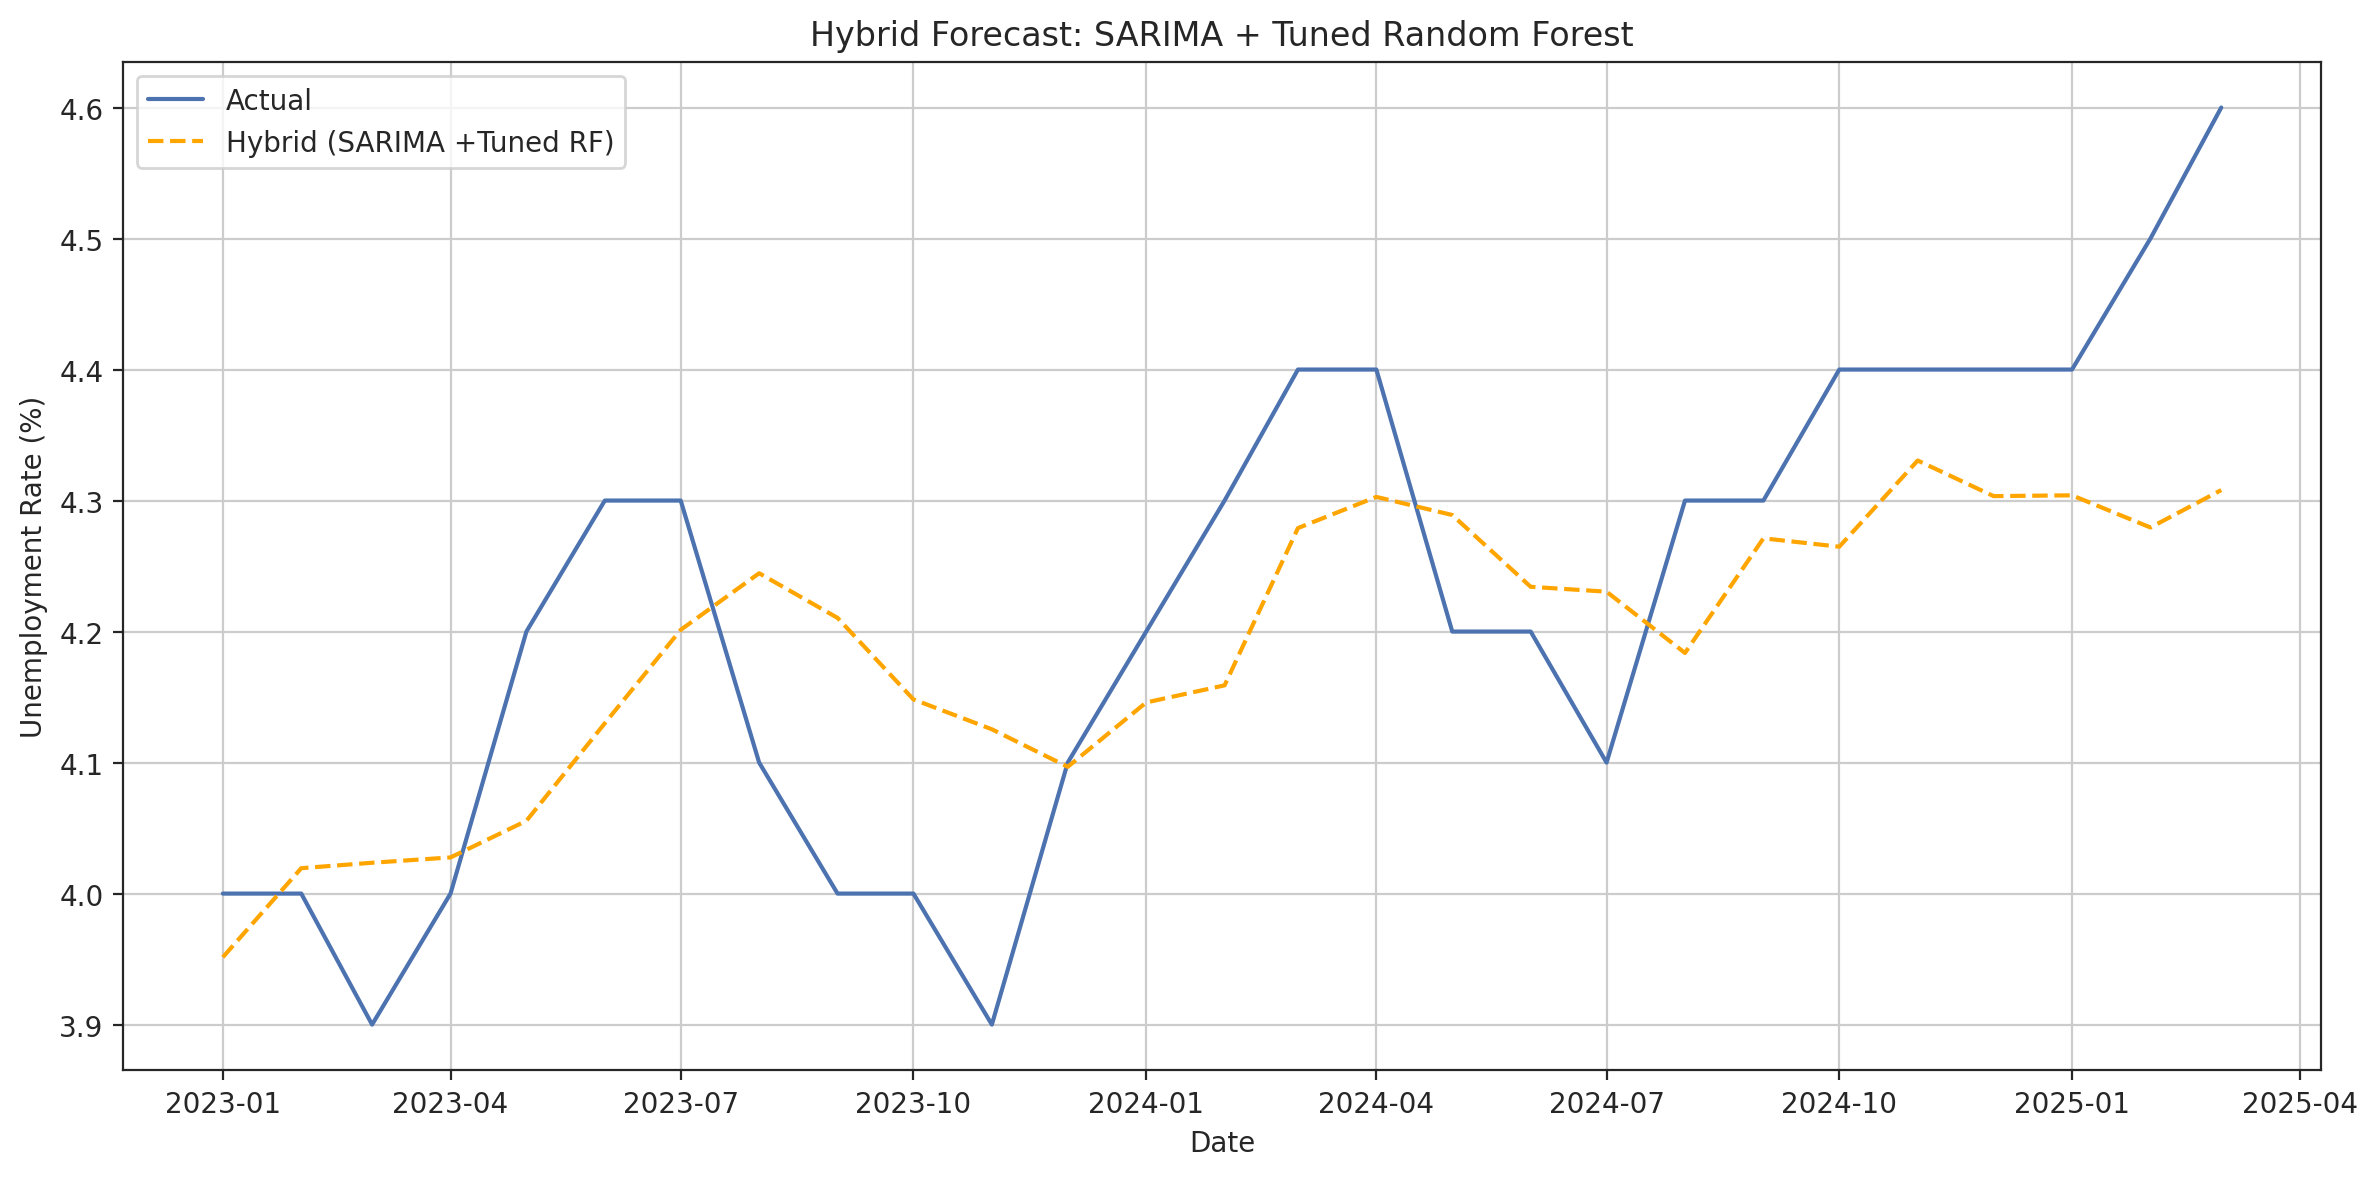

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, trf_hybrid, label='Hybrid (SARIMA +Tuned RF)', linestyle='--', color='orange')
plt.title('Hybrid Forecast: SARIMA + Tuned Random Forest')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Gradient Boosting

Train Gradient Boosting Regressor

In [ ]:
#Train the model
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

#Predict on test set
gb_pred = gb_model.predict(X_test)


 Evaluate Gradient Boosting (Standalone)

In [ ]:
#Evaluate GB alone
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_pred))
gb_mae = mean_absolute_error(y_test, gb_pred)
gb_mape = mean_absolute_percentage_error(y_test, gb_pred) * 100

print(f"Gradient Boosting Only - RMSE: {gb_rmse:.4f}")
print(f"Gradient Boosting Only - MAE: {gb_mae:.4f}")
print(f"Gradient Boosting Only - MAPE: {gb_mape:.2f}%")


Gradient Boosting Only - RMSE: 0.1174
Gradient Boosting Only - MAE: 0.0933
Gradient Boosting Only - MAPE: 2.23%


Create Hybrid (SARIMA + Gradient Boosting)

In [ ]:
#Combine SARIMA + GB with equal weights
GB_hybrid = 0.5 * predicted_sarima.values + 0.5 * gb_pred

Evaluate Hybrid (SARIMA + GB)

In [ ]:
# Evaluate Hybrid Model
rmse_hybrid_gb = np.sqrt(mean_squared_error(y_test, GB_hybrid))
mae_hybrid_gb = mean_absolute_error(y_test, GB_hybrid)
mape_hybrid_gb = mean_absolute_percentage_error(y_test, GB_hybrid) * 100

print(f"Hybrid: SARIMA + GB - RMSE: {rmse_hybrid_gb:.4f}")
print(f"Hybrid: SARIMA + GB - MAE: {mae_hybrid_gb:.4f}")
print(f"Hybrid: SARIMA + GB - MAPE: {mape_hybrid_gb:.2f}%")


Hybrid: SARIMA + GB - RMSE: 0.1151
Hybrid: SARIMA + GB - MAE: 0.0956
Hybrid: SARIMA + GB - MAPE: 2.26%


Plot: SARIMA + Gradient Boosting Hybrid Forecast

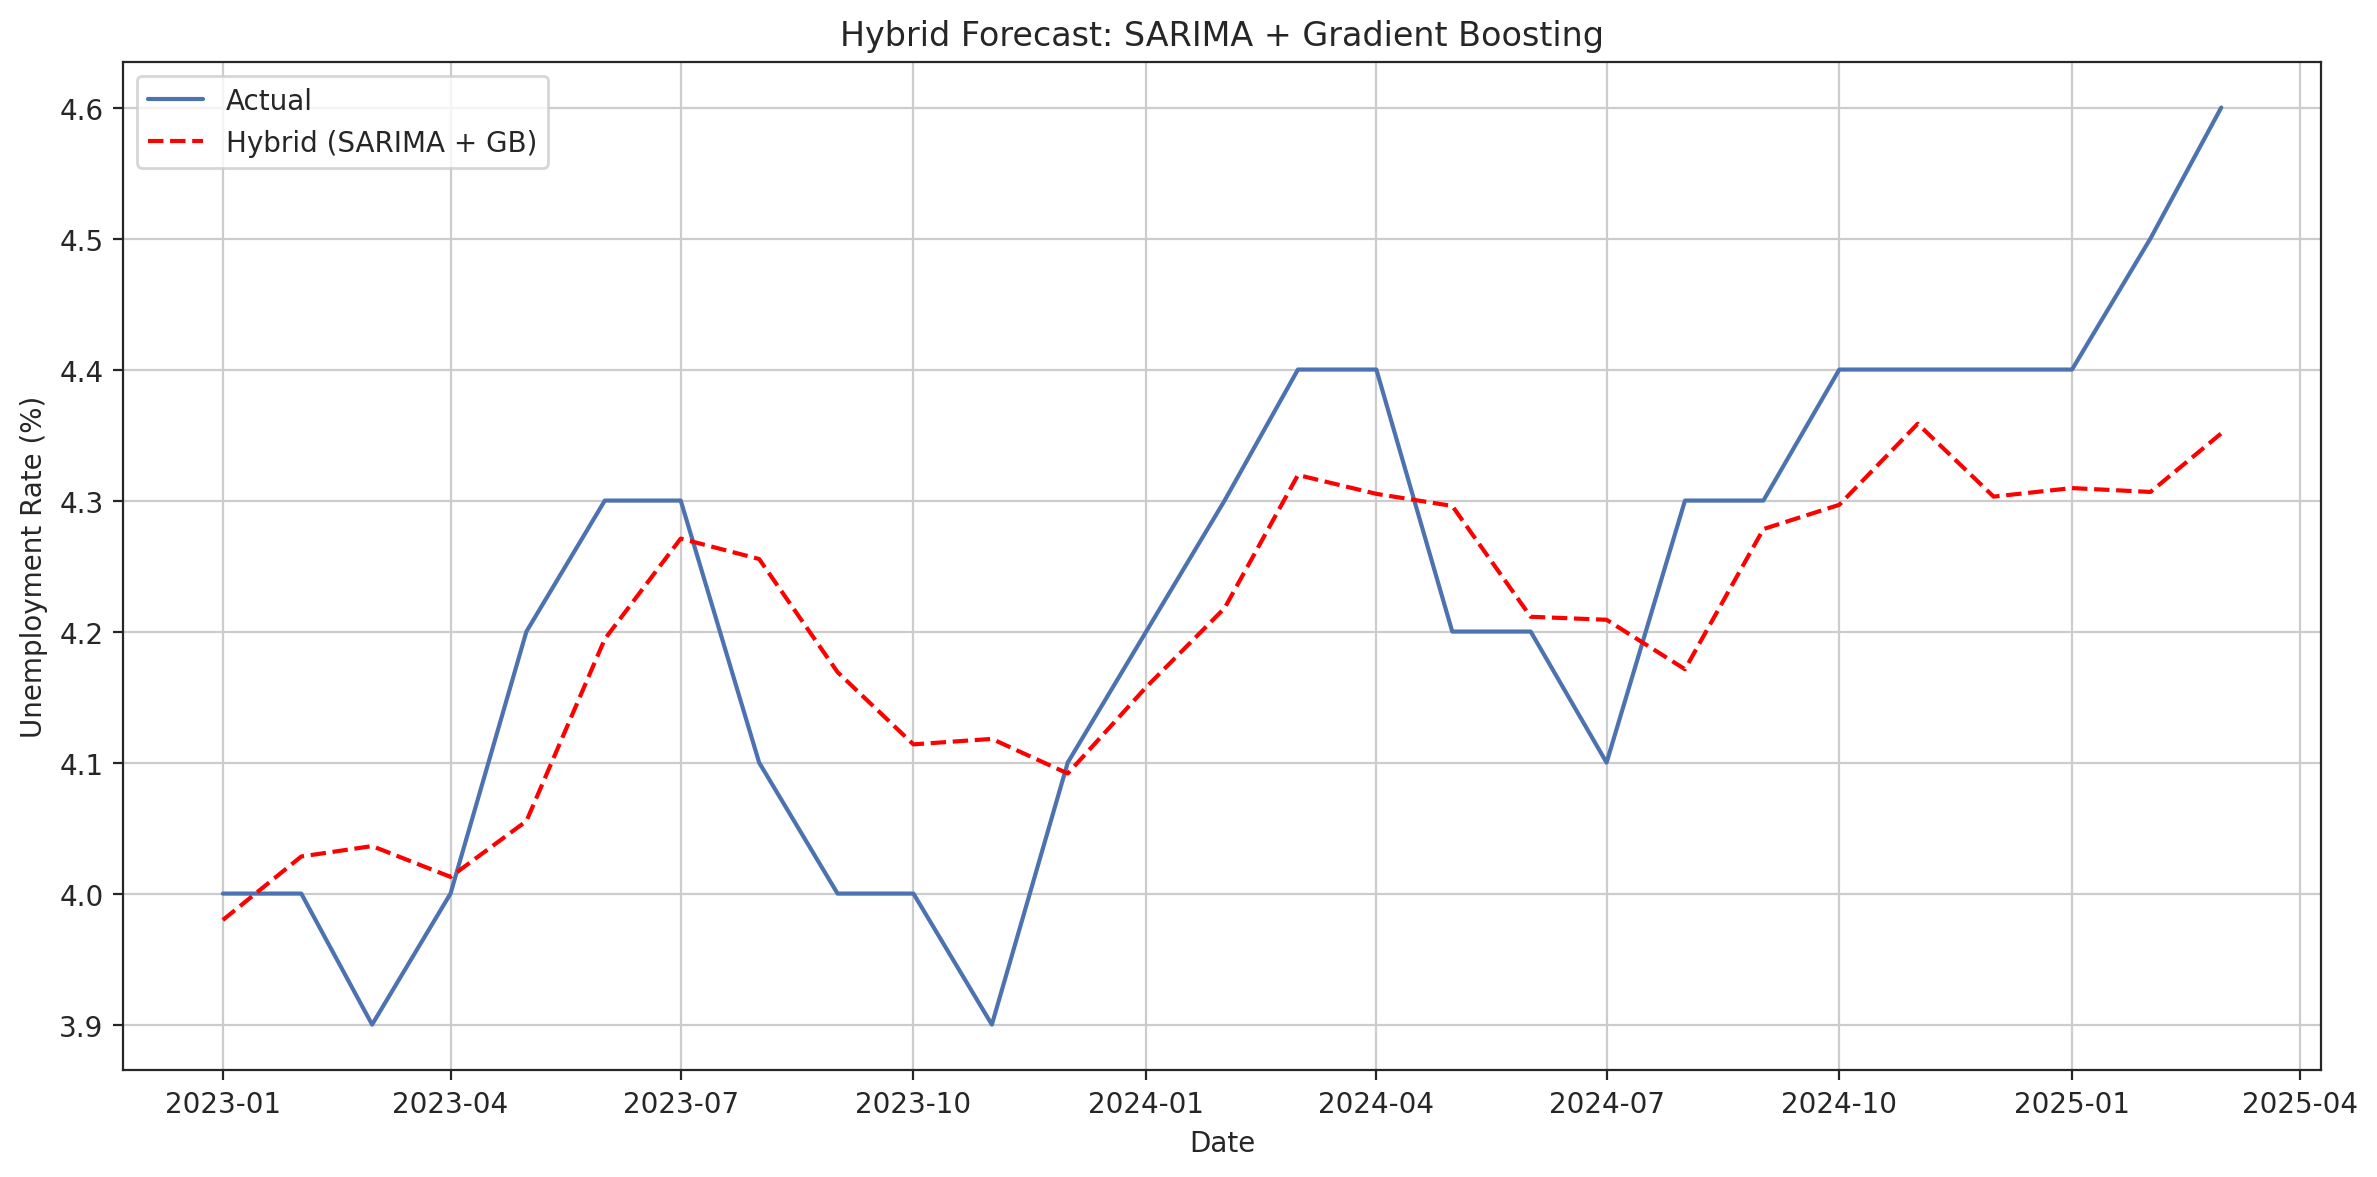

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, GB_hybrid, label='Hybrid (SARIMA + GB)', linestyle='--', color='red')
plt.title('Hybrid Forecast: SARIMA + Gradient Boosting')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Gradient Boosting Hyper Parameter

In [ ]:
#Define base model
gb = GradientBoostingRegressor(random_state=42)

#Define parameter distributions
param_dist = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'subsample': uniform(0.7, 0.3),
    'max_features': ['sqrt', 'log2', None]
}

In [ ]:
#Randomized search
random_search_gb = RandomizedSearchCV(
    estimator=gb,
    param_distributions=param_dist,
    n_iter=25,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

In [ ]:
#Fit search
random_search_gb.fit(X_train, y_train)

#Best model
best_gb = random_search_gb.best_estimator_

print("Best Parameters (GB):", random_search_gb.best_params_)


Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best Parameters (GB): {'learning_rate': np.float64(0.056178765124429805), 'max_depth': 6, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 363, 'subsample': np.float64(0.7103165563345655)}


In [ ]:
#Predict with tuned GB
gb_pred_tuned = best_gb.predict(X_test)

In [ ]:
#Evaluate tuned GB
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_pred_tuned))
gb_mae = mean_absolute_error(y_test, gb_pred_tuned)
gb_mape = mean_absolute_percentage_error(y_test, gb_pred_tuned) * 100

print(f"Tuned GB - RMSE: {gb_rmse:.4f}")
print(f"Tuned GB - MAE: {gb_mae:.4f}")
print(f"Tuned GB - MAPE: {gb_mape:.2f}%")


Tuned GB - RMSE: 0.1522
Tuned GB - MAE: 0.1248
Tuned GB - MAPE: 2.97%


Create Hybrid (SARIMA + Tuned Gradient Boosting)

In [ ]:
#Combine SARIMA + Tuned GB with equal weights
GB_hybrid_tuned = 0.5 * predicted_sarima.values + 0.5 * gb_pred_tuned

Evaluate Hybrid (SARIMA + Tuned GB)

In [ ]:
rmse_hybrid_gb = np.sqrt(mean_squared_error(y_test, GB_hybrid_tuned))
mae_hybrid_gb = mean_absolute_error(y_test, GB_hybrid_tuned)
mape_hybrid_gb = mean_absolute_percentage_error(y_test, GB_hybrid_tuned) * 100

print(f"Hybrid: SARIMA + Tuned GB - RMSE: {rmse_hybrid_gb:.4f}")
print(f"Hybrid: SARIMA + Tuned GB - MAE: {mae_hybrid_gb:.4f}")
print(f"Hybrid: SARIMA + Tuned GB - MAPE: {mape_hybrid_gb:.2f}%")

Hybrid: SARIMA + Tuned GB - RMSE: 0.1199
Hybrid: SARIMA + Tuned GB - MAE: 0.0940
Hybrid: SARIMA + Tuned GB - MAPE: 2.24%


## XGBoost

In [ ]:
pip install xgboost

In [ ]:
#Train XGBoost Model
xgb_model = xgb.XGBRegressor(random_state=42, n_estimators=100)
xgb_model.fit(X_train, y_train)

#Predict with XGBoost
xgb_pred = xgb_model.predict(X_test)


Evaluate XGBoost (Standalone)

In [ ]:
#Evaluate XGBoost Alone
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_mape = mean_absolute_percentage_error(y_test, xgb_pred) * 100

print(f"XGBoost Only - RMSE: {xgb_rmse:.4f}")
print(f"XGBoost Only - MAE: {xgb_mae:.4f}")
print(f"XGBoost Only - MAPE: {xgb_mape:.2f}%")


XGBoost Only - RMSE: 0.1248
XGBoost Only - MAE: 0.1097
XGBoost Only - MAPE: 2.60%


Create Hybrid (SARIMA + Xgboost)

In [ ]:
#Align SARIMA predictions with test set
hybrid_xgb = 0.5 * predicted_sarima.values + 0.5 * xgb_pred

Evaluate Hybrid (SARIMA + Xgboost)

In [ ]:
#Evaluate Hybrid SARIMA + XGBoost
hybrid_rmse = np.sqrt(mean_squared_error(y_test, hybrid_xgb))
hybrid_mae = mean_absolute_error(y_test, hybrid_xgb)
hybrid_mape = mean_absolute_percentage_error(y_test, hybrid_xgb) * 100

print(f"Hybrid: SARIMA + XGBoost - RMSE: {hybrid_rmse:.4f}")
print(f"Hybrid: SARIMA + XGBoost - MAE: {hybrid_mae:.4f}")
print(f"Hybrid: SARIMA + XGBoost - MAPE: {hybrid_mape:.2f}%")

Hybrid: SARIMA + XGBoost - RMSE: 0.1178
Hybrid: SARIMA + XGBoost - MAE: 0.0997
Hybrid: SARIMA + XGBoost - MAPE: 2.35%


 Plot the Hybrid SARIMA + XGBoost Forecast

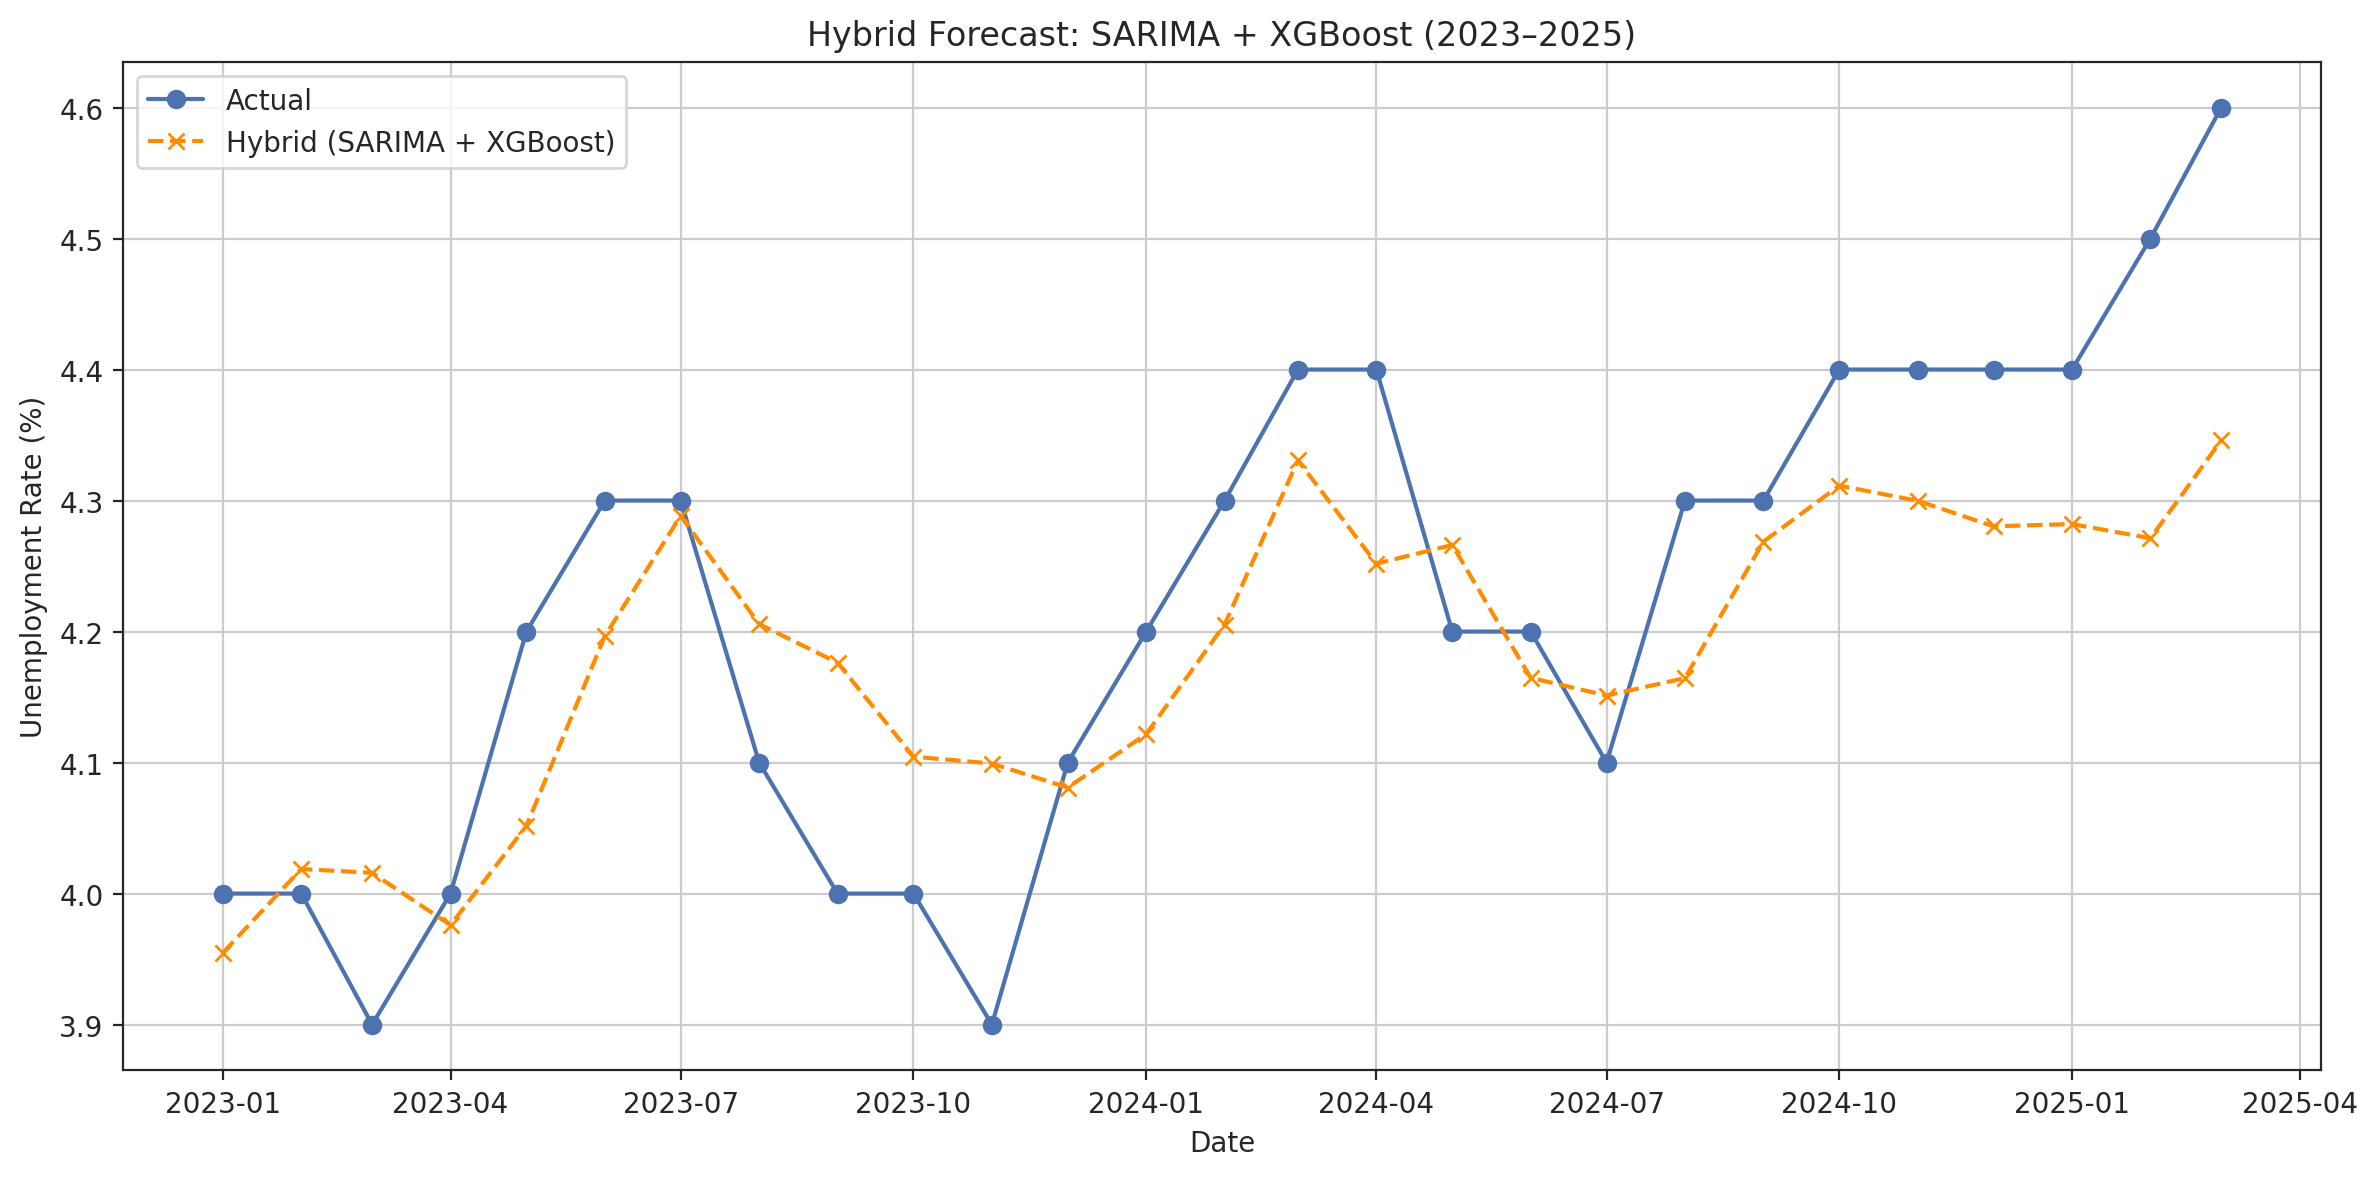

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', marker='o')
plt.plot(y_test.index, hybrid_xgb, label='Hybrid (SARIMA + XGBoost)', linestyle='--', marker='x', color='darkorange')
plt.title('Hybrid Forecast: SARIMA + XGBoost (2023–2025)')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## XGBoost Hyper Parameter Tuning

In [ ]:
#Base model
xgb_base = XGBRegressor(random_state=42, objective='reg:squarederror')

#Parameter distributions
param_dist = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'min_child_weight': randint(1, 6),
    'gamma': uniform(0, 0.3)
}

In [ ]:
#Randomized Search
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=25,
    cv = TimeSeriesSplit(n_splits=3),
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

In [ ]:
#Fit search
random_search_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamm...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7aeab1d047d0>,
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7aeab3957e00>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7aeab9b83500>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7aeab1cd5cd0>},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [ ]:
#Best tuned model
best_xgb = random_search_xgb.best_estimator_
print("Best Parameters (XGB):", random_search_xgb.best_params_)

#Predict with tuned XGB
xgb_pred_tuned = best_xgb.predict(X_test)


Best Parameters (XGB): {'colsample_bytree': np.float64(0.9425192044349383), 'gamma': np.float64(0.0913841307520112), 'learning_rate': np.float64(0.03930163420191516), 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 466, 'subsample': np.float64(0.9049790556476374)}


In [ ]:
#Evaluate tuned XGB
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred_tuned))
xgb_mae = mean_absolute_error(y_test, xgb_pred_tuned)
xgb_mape = mean_absolute_percentage_error(y_test, xgb_pred_tuned) * 100

print(f"Tuned XGB - RMSE: {xgb_rmse:.4f}")
print(f"Tuned XGB - MAE: {xgb_mae:.4f}")
print(f"Tuned XGB - MAPE: {xgb_mape:.4f}%")

Tuned XGB - RMSE: 0.1167
Tuned XGB - MAE: 0.0974
Tuned XGB - MAPE: 2.3146%


Create Hybrid (SARIMA + Tunned Xgboost)

In [ ]:
#Hybrid SARIMA + Tuned XGB
hybrid_xgb_tuned = 0.5 * predicted_sarima.values + 0.5 * xgb_pred_tuned

Evaluate Hybrid (SARIMA + Tuned Xgboost)

In [ ]:
#Evaluate Hybrid
hybrid_rmse = np.sqrt(mean_squared_error(y_test, hybrid_xgb_tuned))
hybrid_mae = mean_absolute_error(y_test, hybrid_xgb_tuned)
hybrid_mape = mean_absolute_percentage_error(y_test, hybrid_xgb_tuned) * 100

print(f"Hybrid: SARIMA + Tuned XGB - RMSE: {hybrid_rmse:.4f}")
print(f"Hybrid: SARIMA + Tuned XGB - MAE: {hybrid_mae:.4f}")
print(f"Hybrid: SARIMA + Tuned XGB - MAPE: {hybrid_mape:.2f}%")

Hybrid: SARIMA + Tuned XGB - RMSE: 0.1205
Hybrid: SARIMA + Tuned XGB - MAE: 0.1032
Hybrid: SARIMA + Tuned XGB - MAPE: 2.44%


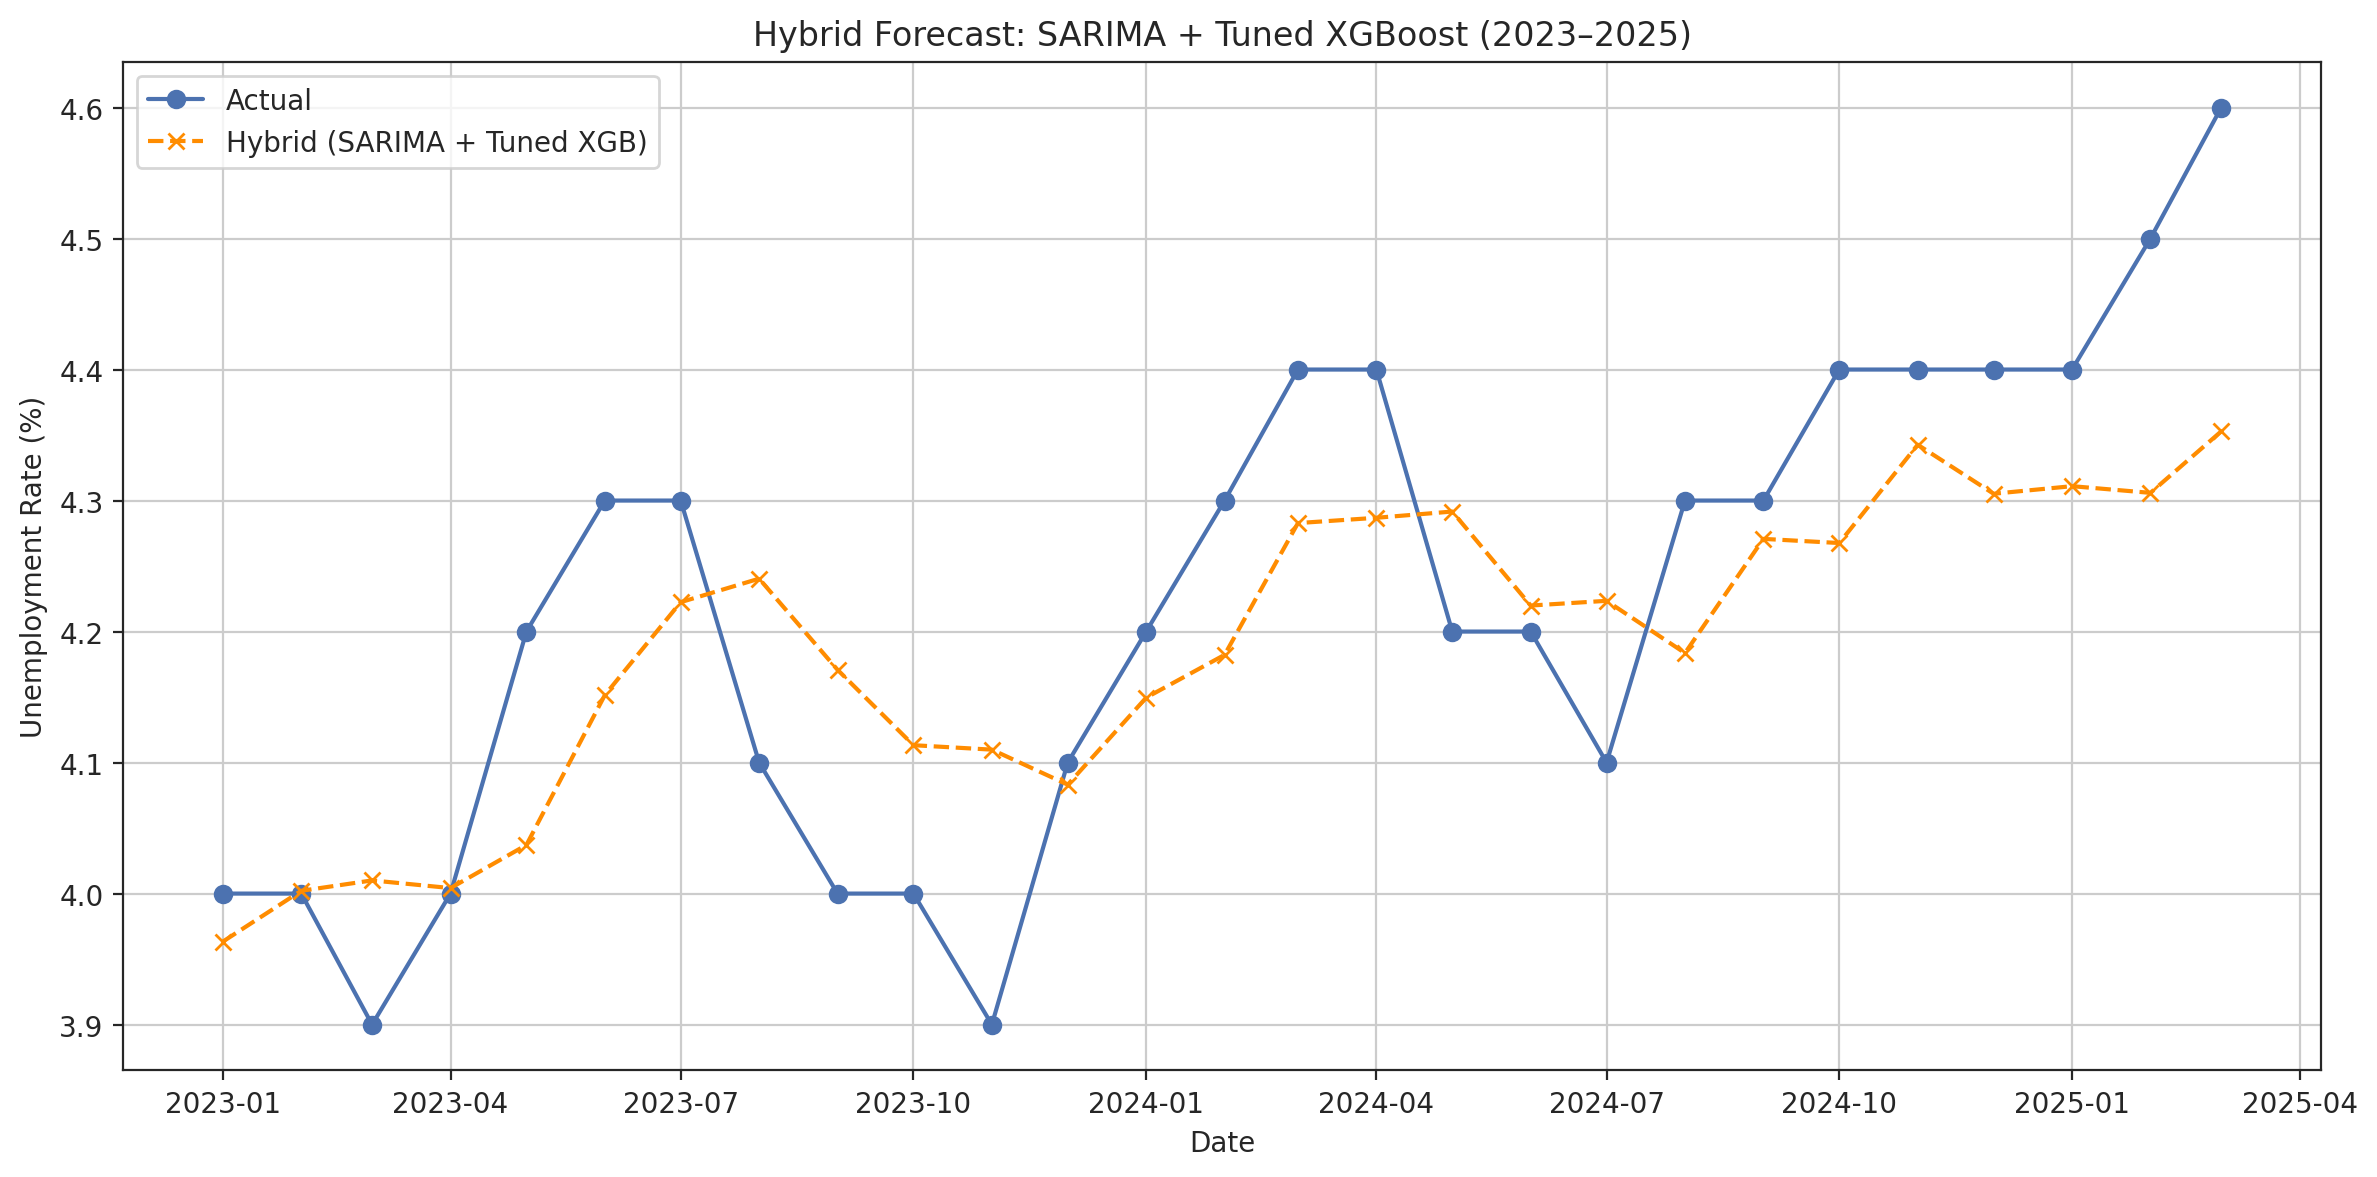

In [ ]:
# Plot Hybrid Forecast
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', marker='o')
plt.plot(y_test.index, hybrid_xgb_tuned, label='Hybrid (SARIMA + Tuned XGB)', linestyle='--', marker='x', color='darkorange')
plt.title('Hybrid Forecast: SARIMA + Tuned XGBoost (2023–2025)')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## LSTM

Install & Import Required Libraries

In [ ]:
# Install
!pip install tensorflow

Prepare the Data for LSTM

In [ ]:
#Using only unemployment column
unemployment_series = mdata[['Unemployment']].copy()

#Scaling the data to range [0,1]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(unemployment_series)

In [ ]:
#Converting to numpy array to fix slicing error
scaled_data = np.array(scaled_data)

#Definning function to create time windows
def create_lstm_dataset(data, time_steps=12):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

#create the dataset
X_all, y_all = create_lstm_dataset(scaled_data, time_steps=12)


In [ ]:
#Split to match the SARIMA test period (train: up to 2022-12, test: from 2023-01)
split_index = len(mdata.loc[:'2022-12-01']) - 12  # minus 12 for lookback
X_train, X_test = X_all[:split_index], X_all[split_index:]
y_train, y_test = y_all[:split_index], y_all[split_index:]

#Reshaping for LSTM: (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


Build and Train the LSTM Model

In [ ]:
#Definning the LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

#Training the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)


 Evaluate LSTM Model

In [ ]:
#Predict on test set
lstm_pred_scaled = model.predict(X_test)

#Inverse scale
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


In [ ]:
#Evaluation
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_pred))
lstm_mae = mean_absolute_error(y_test_actual, lstm_pred)
lstm_mape = mean_absolute_percentage_error(y_test_actual, lstm_pred) * 100

print(f"LSTM Only - RMSE: {lstm_rmse:.4f}")
print(f"LSTM Only - MAE: {lstm_mae:.4f}")
print(f"LSTM Only - MAPE: {lstm_mape:.4f}%")

LSTM Only - RMSE: 0.1614
LSTM Only - MAE: 0.1353
LSTM Only - MAPE: 3.2457%


Combine SARIMA + LSTM (50-50 Weighted Average)

In [ ]:
#Ensuring SARIMA prediction and LSTM prediction are aligned
hybrid_lstm = 0.5 * predicted_sarima.values + 0.5 * lstm_pred.flatten()


Evaluate Hybrid SARIMA + LSTM

In [ ]:
rmse_hybrid_lstm = np.sqrt(mean_squared_error(y_test_actual, hybrid_lstm))
mae_hybrid_lstm = mean_absolute_error(y_test_actual, hybrid_lstm)
mape_hybrid_lstm = mean_absolute_percentage_error(y_test_actual, hybrid_lstm) * 100

print(f"Hybrid: SARIMA + LSTM - RMSE: {rmse_hybrid_lstm:.4f}")
print(f"Hybrid: SARIMA + LSTM - MAE: {mae_hybrid_lstm:.4f}")
print(f"Hybrid: SARIMA + LSTM - MAPE: {mape_hybrid_lstm:.2f}%")

Hybrid: SARIMA + LSTM - RMSE: 0.1364
Hybrid: SARIMA + LSTM - MAE: 0.1233
Hybrid: SARIMA + LSTM - MAPE: 2.93%


Plot Hybrid Forecast vs Actual

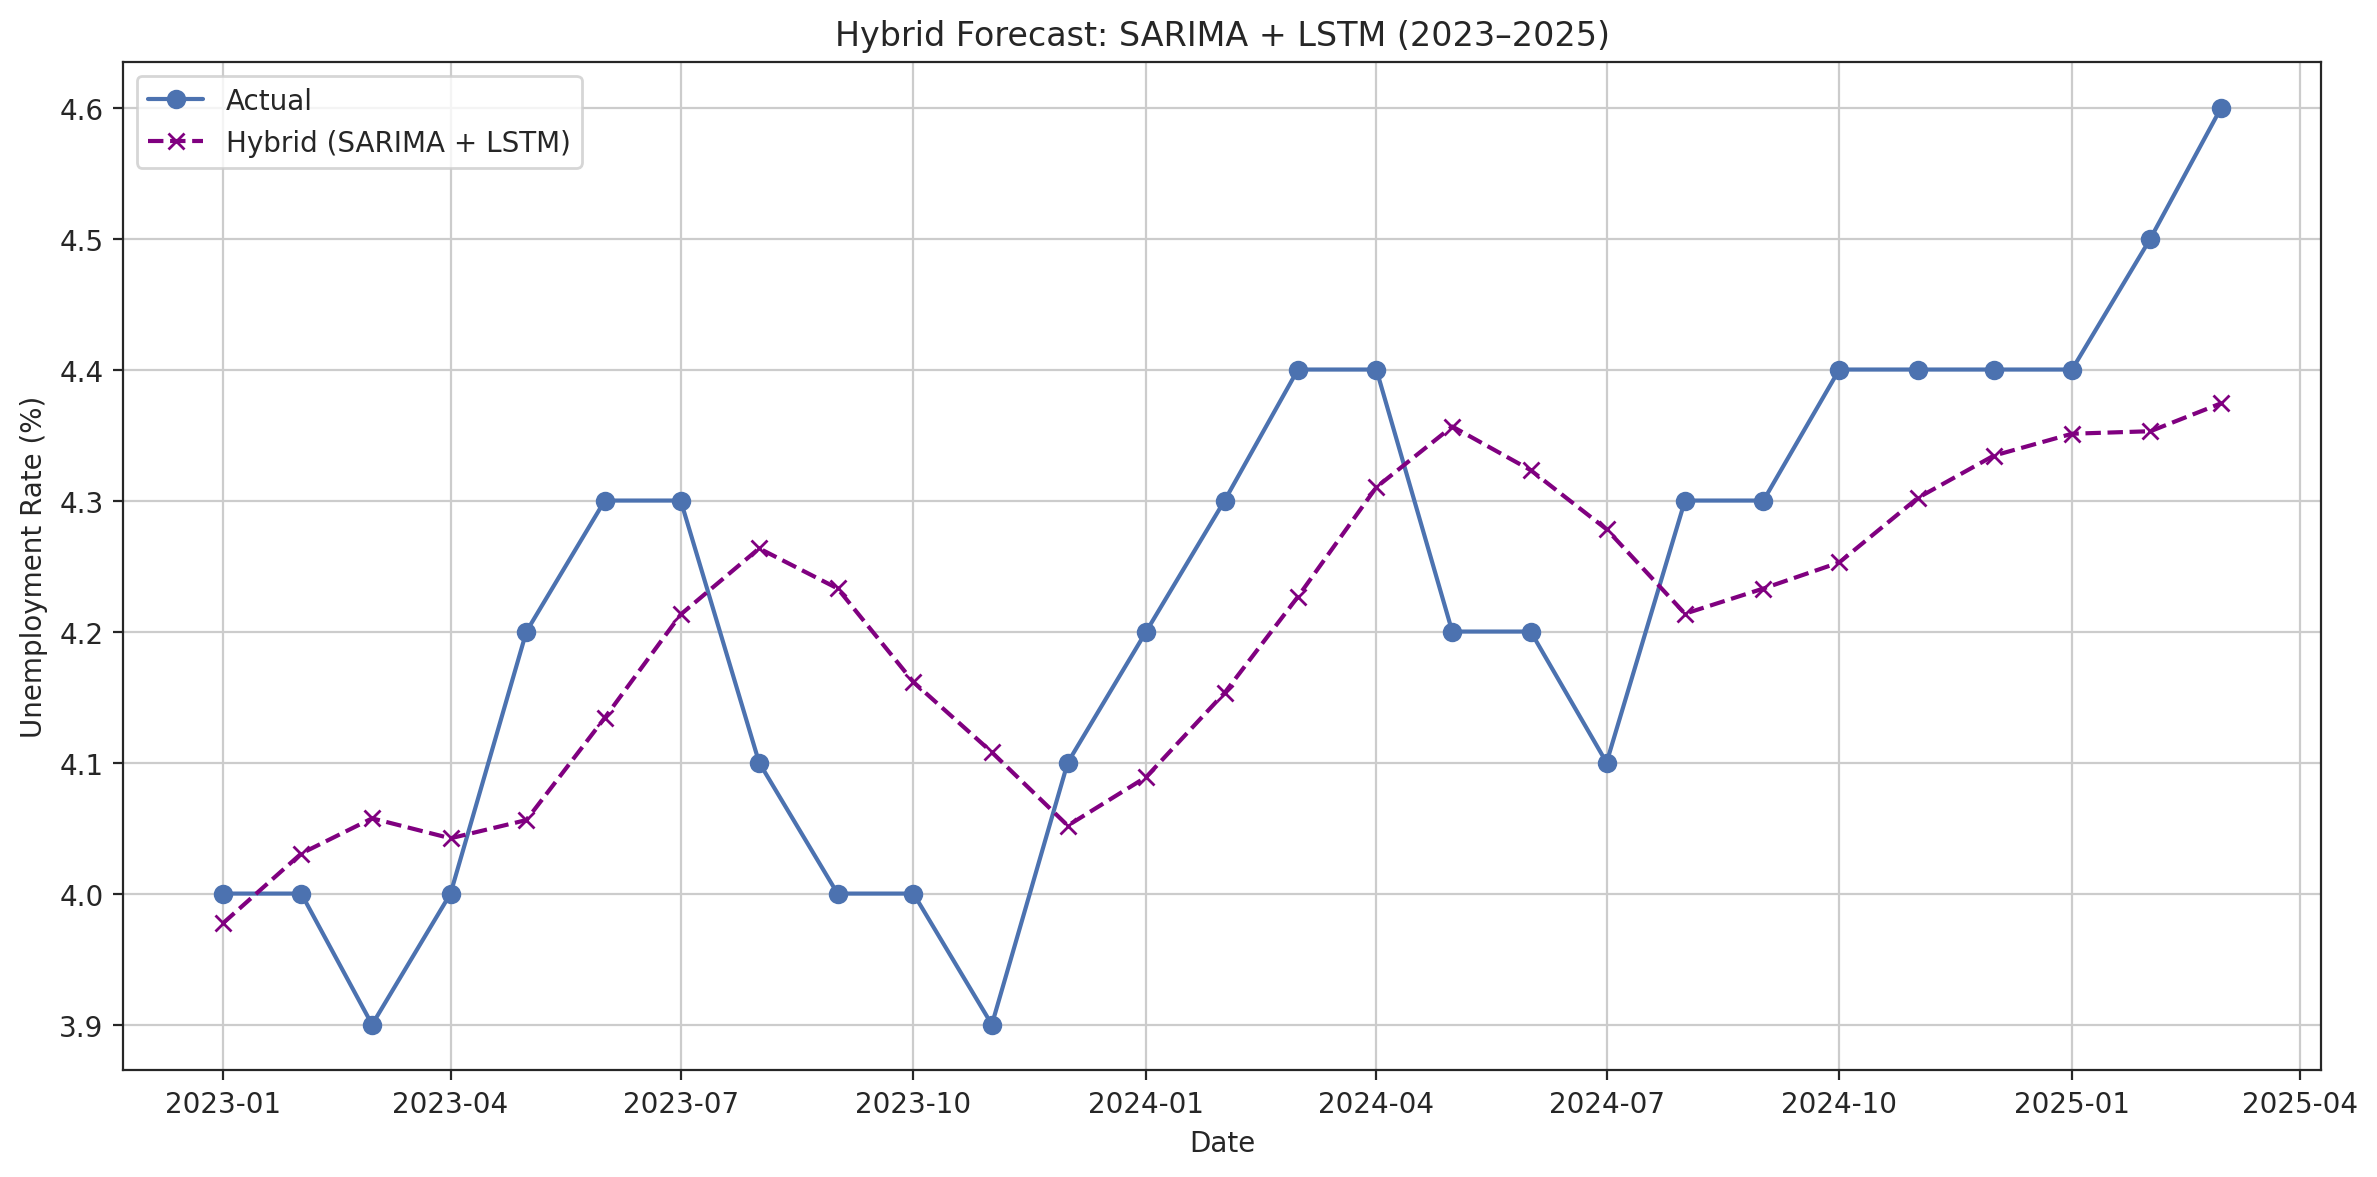

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test_sarima.index, y_test_actual, label='Actual', marker='o')
plt.plot(test_sarima.index, hybrid_lstm, label='Hybrid (SARIMA + LSTM)', linestyle='--', marker='x', color='purple')
plt.title('Hybrid Forecast: SARIMA + LSTM (2023–2025)')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## LSTM Hyper Parameter Tuning

In [ ]:
# Define tuned LSTM model
model = Sequential()
model.add(LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile with smaller learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [ ]:
# Train with validation split
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=16,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=0
)

In [ ]:
# Predict
lstm_pred_scaled = model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


In [ ]:
# Evaluate LSTM standalone
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_pred))
lstm_mae = mean_absolute_error(y_test_actual, lstm_pred)
lstm_mape = mean_absolute_percentage_error(y_test_actual, lstm_pred) * 100

print(f"Tuned LSTM Only - RMSE: {lstm_rmse:.4f}")
print(f"Tuned LSTM Only - MAE: {lstm_mae:.4f}")
print(f"Tuned LSTM Only - MAPE: {lstm_mape:.4f}%")

Tuned LSTM Only - RMSE: 0.1788
Tuned LSTM Only - MAE: 0.1541
Tuned LSTM Only - MAPE: 3.6672%


Combine SARIMA + Tuned LSTM (50-50 Weighted Average)

In [ ]:
# Hybrid SARIMA + LSTM (equal weights)
hybrid_lstm = 0.5 * predicted_sarima.values + 0.5 * lstm_pred.flatten()

Evaluate Hybrid : SARIMA + Tuned LSTM

In [ ]:
# Evaluate Hybrid
rmse_hybrid_lstm = np.sqrt(mean_squared_error(y_test_actual, hybrid_lstm))
mae_hybrid_lstm = mean_absolute_error(y_test_actual, hybrid_lstm)
mape_hybrid_lstm = mean_absolute_percentage_error(y_test_actual, hybrid_lstm) * 100

print(f"Hybrid: SARIMA + Tuned LSTM - RMSE: {rmse_hybrid_lstm:.4f}")
print(f"Hybrid: SARIMA + Tuned LSTM - MAE: {mae_hybrid_lstm:.4f}")
print(f"Hybrid: SARIMA + Tuned LSTM - MAPE: {mape_hybrid_lstm:.4f}%")

Hybrid: SARIMA + Tuned LSTM - RMSE: 0.1577
Hybrid: SARIMA + Tuned LSTM - MAE: 0.1362
Hybrid: SARIMA + Tuned LSTM - MAPE: 3.2249%


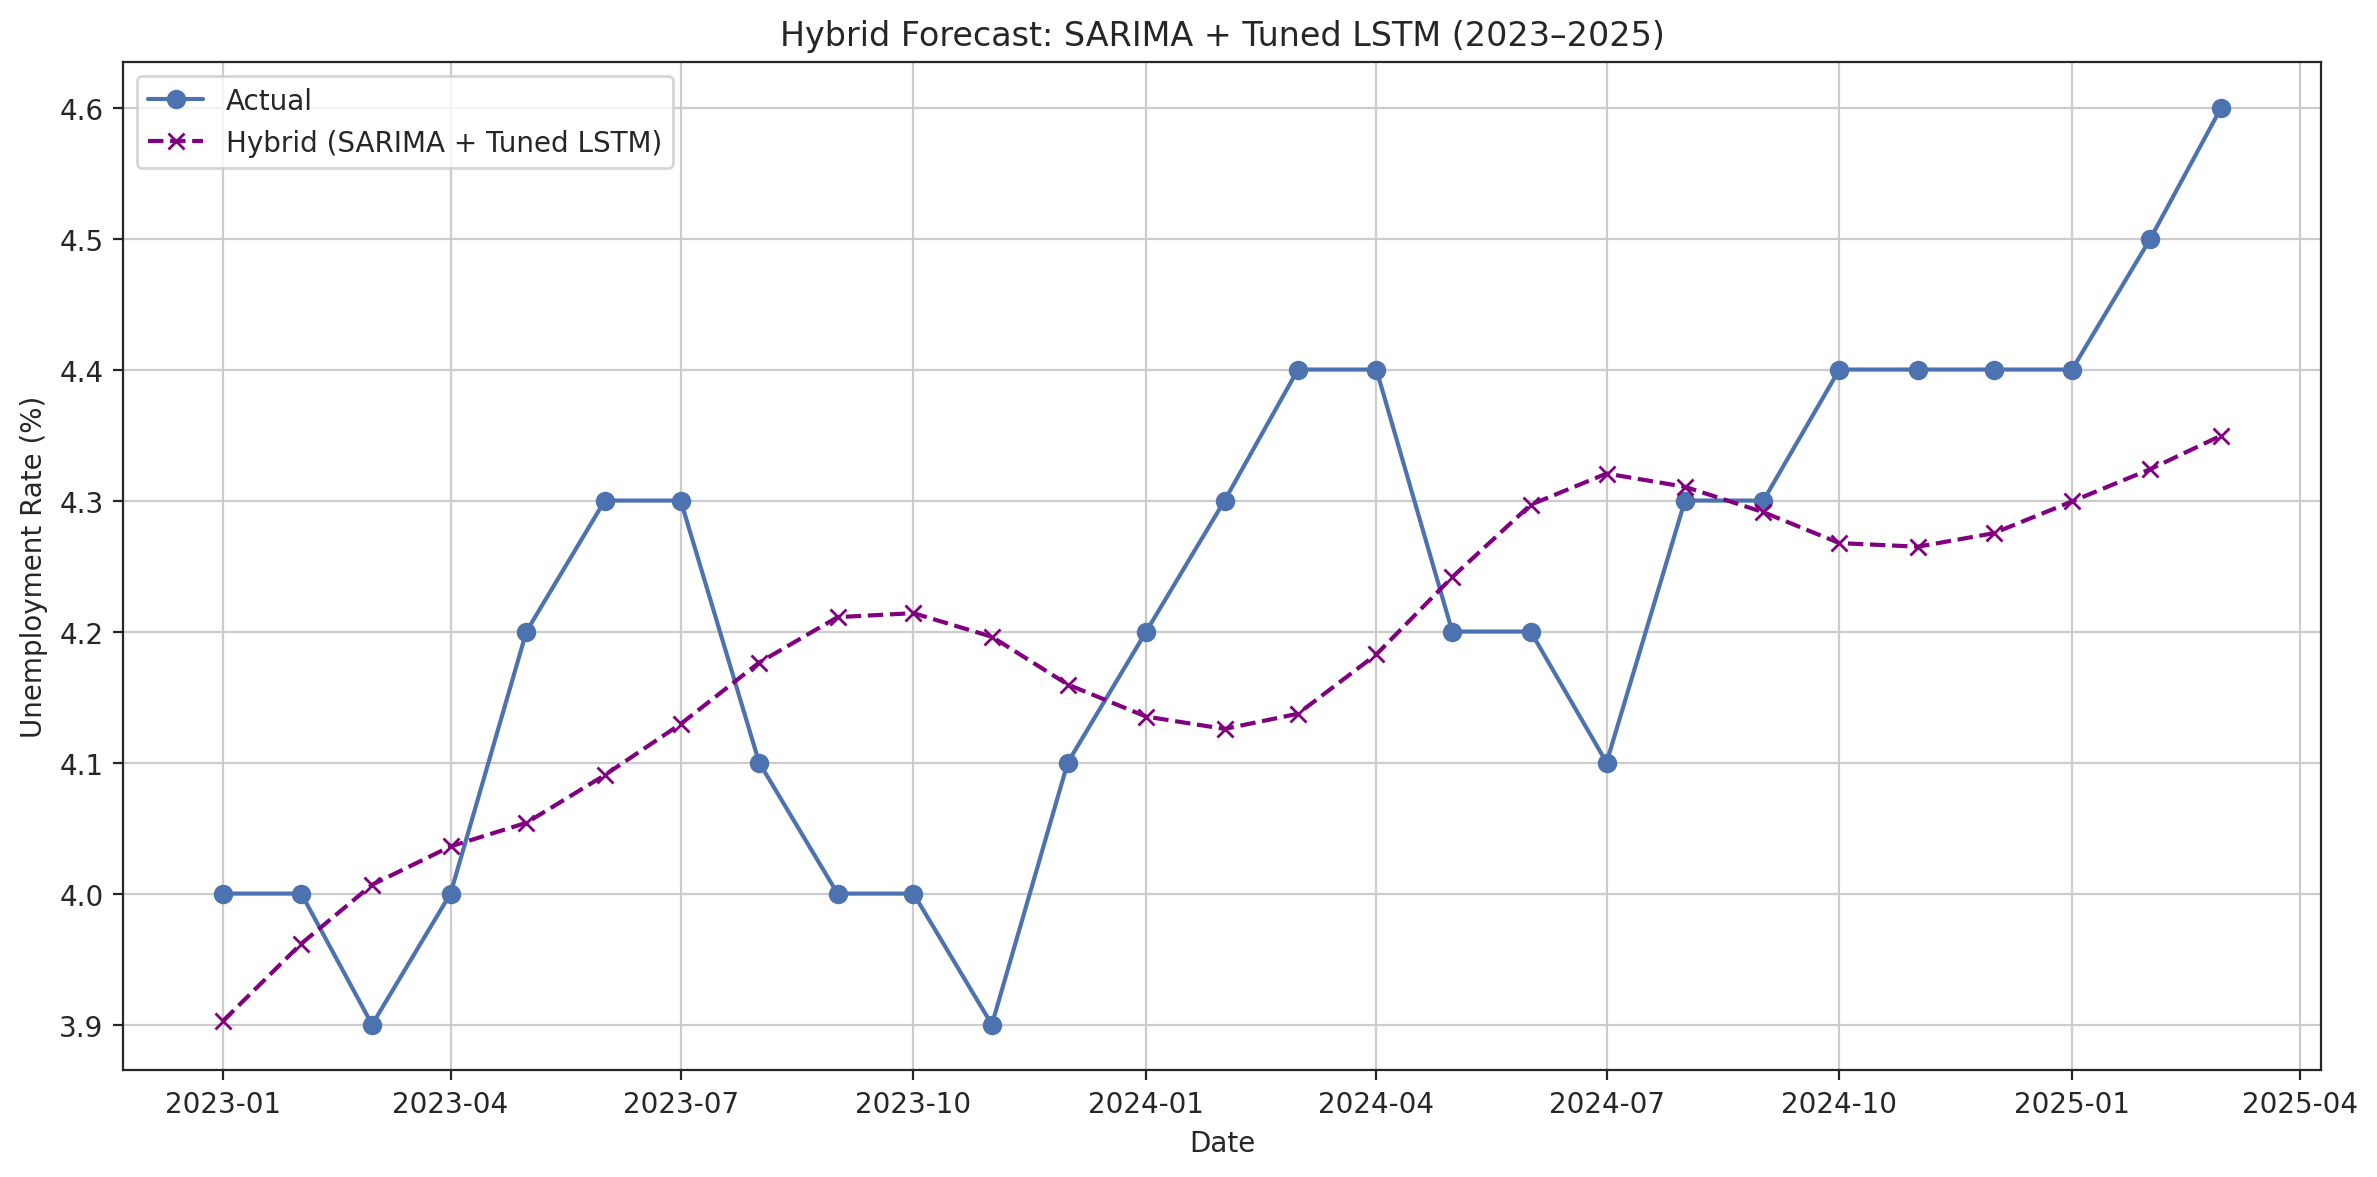

In [ ]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(test_sarima.index, y_test_actual, label='Actual', marker='o')
plt.plot(test_sarima.index, hybrid_lstm, label='Hybrid (SARIMA + Tuned LSTM)', linestyle='--', marker='x', color='purple')
plt.title('Hybrid Forecast: SARIMA + Tuned LSTM (2023–2025)')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## CNN

Prepare CNN

In [ ]:
#Reusing from earlier
#X_all, y_all already created with time_steps=12
#Using the same split index
split_index = len(mdata.loc[:'2022-12-01']) - 12

#Splitting into training and testing
X_train, X_test = X_all[:split_index], X_all[split_index:]
y_train, y_test = y_all[:split_index], y_all[split_index:]

#Reshaping for CNN: (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

 Build and Train CNN Model

In [ ]:
#Build cnn
# Build CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn_model.add(Flatten())
cnn_model.add(Dense(50, activation='relu'))
cnn_model.add(Dense(1))
cnn_model.compile(optimizer='adam', loss='mse')

# Train CNN
cnn_model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)


 Predict and Evaluate CNN Alone

In [ ]:
#Predict
cnn_pred_scaled = cnn_model.predict(X_test)

#Inverse scale
cnn_pred = scaler.inverse_transform(cnn_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


In [ ]:
#Evaluate CNN
cnn_rmse = np.sqrt(mean_squared_error(y_test_actual, cnn_pred))
cnn_mae = mean_absolute_error(y_test_actual, cnn_pred)
cnn_mape = mean_absolute_percentage_error(y_test_actual, cnn_pred) * 100

print(f"CNN Only - RMSE: {cnn_rmse:.4f}")
print(f"CNN Only - MAE: {cnn_mae:.4f}")
print(f"CNN Only - MAPE: {cnn_mape:.2f}%")

CNN Only - RMSE: 0.1268
CNN Only - MAE: 0.0931
CNN Only - MAPE: 2.24%


Build SARIMA + CNN Hybrid

In [ ]:
#Hybrid = average of SARIMA + CNN
hybrid_cnn = 0.5 * predicted_sarima.values + 0.5 * cnn_pred.flatten()

Evaluate Hybrid (SARIMA + CNN)

In [ ]:
#Evaluate hybrid
hybrid_rmse_cnn = np.sqrt(mean_squared_error(y_test_actual, hybrid_cnn))
hybrid_mae_cnn = mean_absolute_error(y_test_actual, hybrid_cnn)
hybrid_mape_cnn = mean_absolute_percentage_error(y_test_actual, hybrid_cnn) * 100

print(f"Hybrid: SARIMA + CNN - RMSE: {hybrid_rmse_cnn:.4f}")
print(f"Hybrid: SARIMA + CNN - MAE: {hybrid_mae_cnn:.4f}")
print(f"Hybrid: SARIMA + CNN - MAPE: {hybrid_mape_cnn:.2f}%")

Hybrid: SARIMA + CNN - RMSE: 0.1085
Hybrid: SARIMA + CNN - MAE: 0.0906
Hybrid: SARIMA + CNN - MAPE: 2.16%


Plot Hybrid SARIMA + CNN

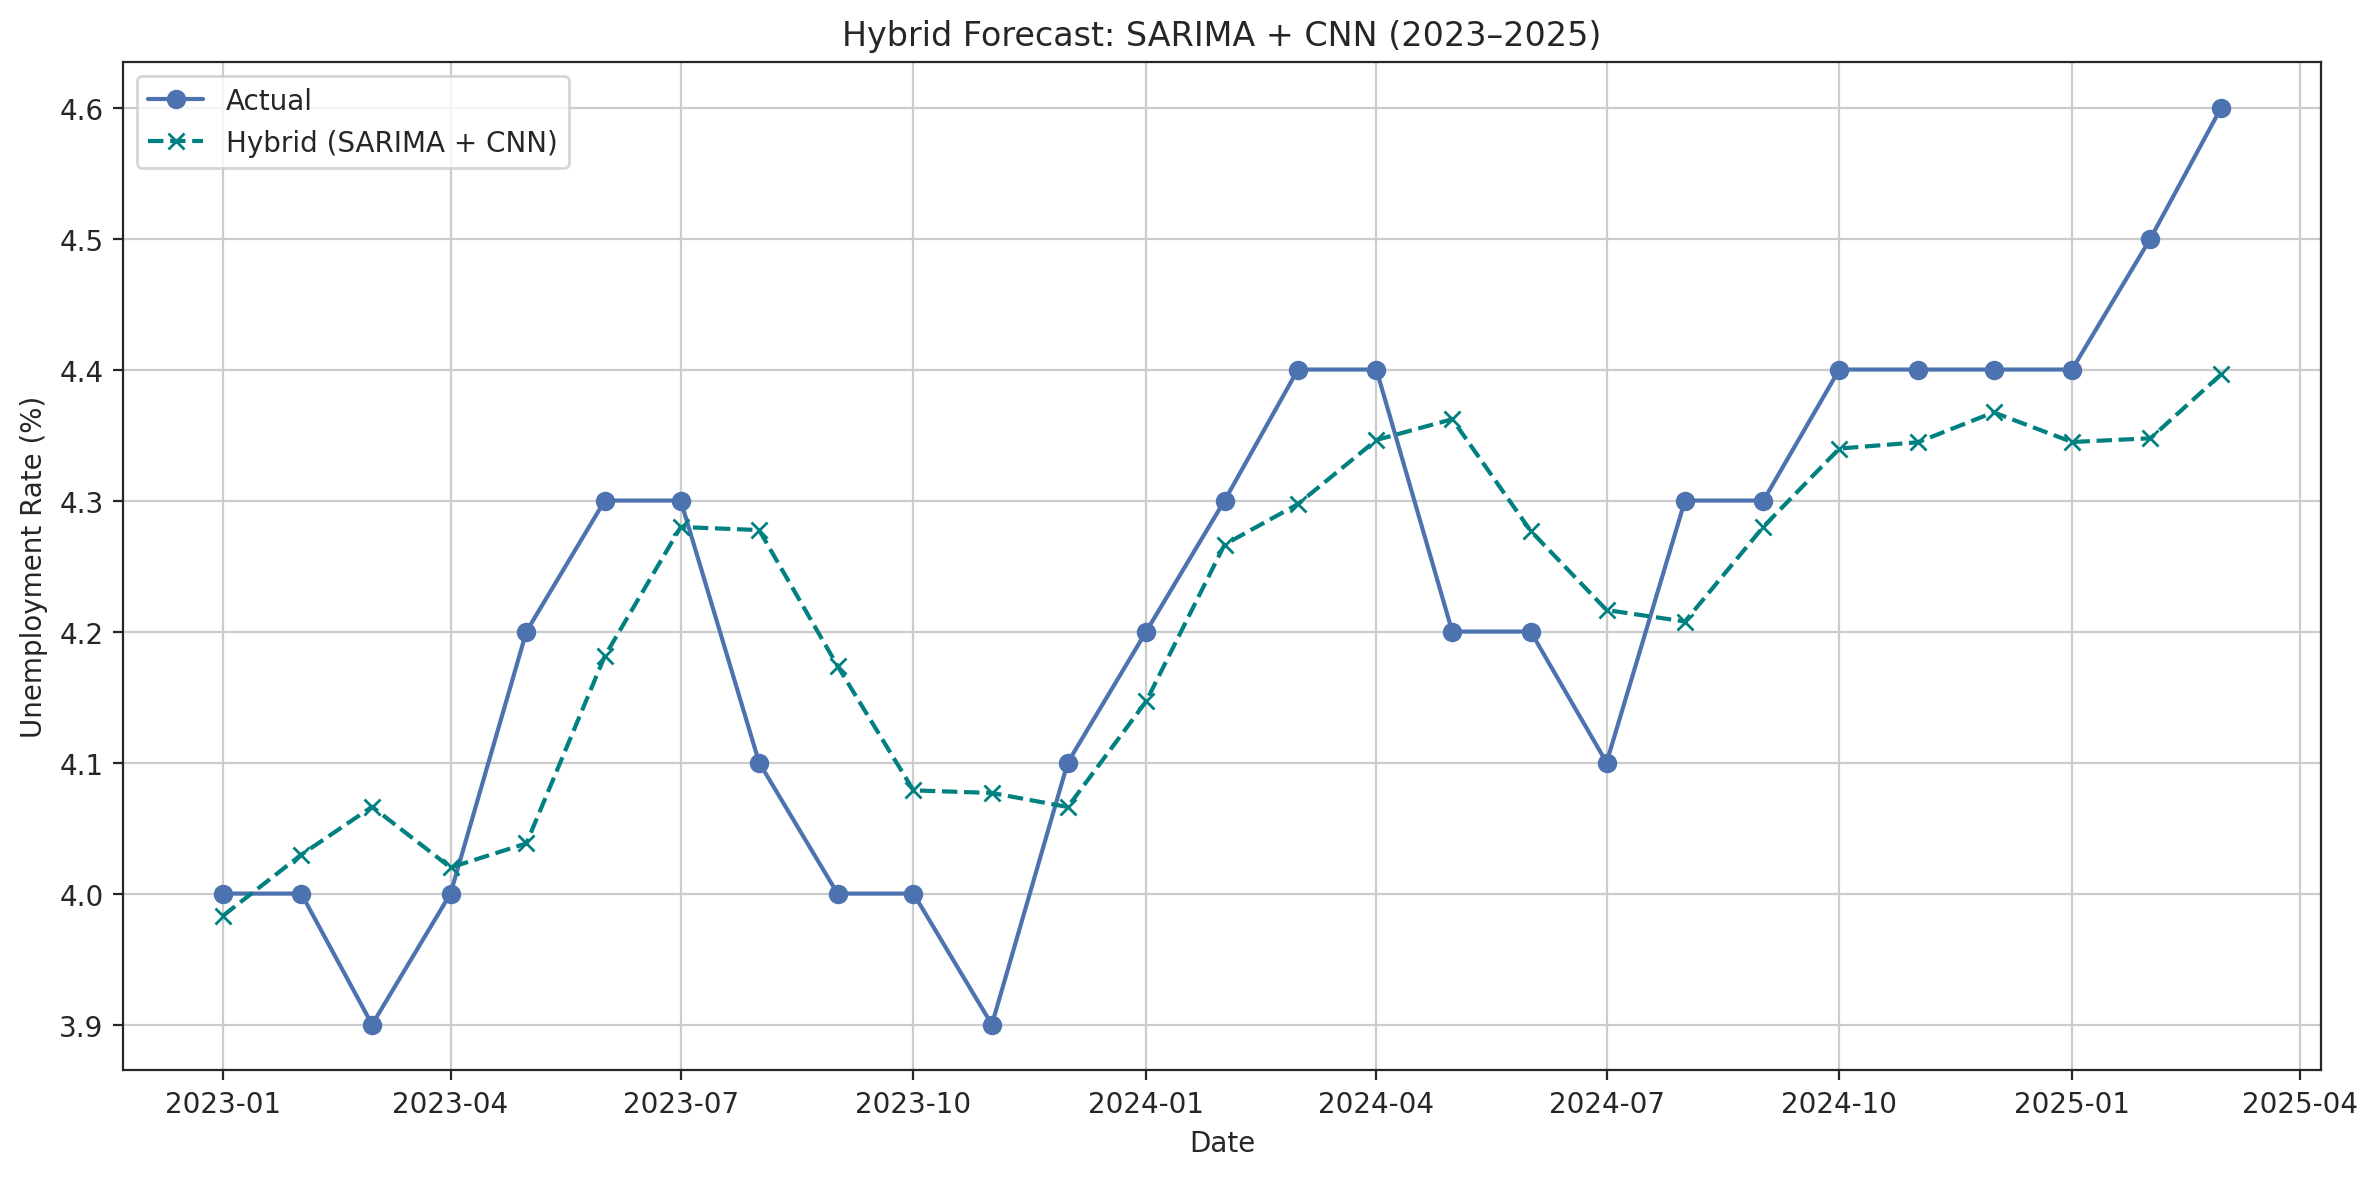

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test_sarima.index, y_test_actual, label='Actual', marker='o')
plt.plot(test_sarima.index, hybrid_cnn, label='Hybrid (SARIMA + CNN)', linestyle='--', marker='x', color='teal')
plt.title('Hybrid Forecast: SARIMA + CNN (2023–2025)')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## CNN Hyper Parameter Tunning

In [ ]:
# Build tuned CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal', input_shape=(X_train.shape[1], 1)))
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='causal'))
cnn_model.add(Dropout(0.2))
cnn_model.add(GlobalAveragePooling1D())
cnn_model.add(Dense(50, activation='relu'))
cnn_model.add(Dense(1))

In [ ]:
# Compile with lower LR for stability
optimizer = Adam(learning_rate=0.001)
cnn_model.compile(optimizer=optimizer, loss='mse')

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [ ]:
# Train with validation split
cnn_model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=16,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=0
)

In [ ]:
# Predict
cnn_pred_scaled = cnn_model.predict(X_test)
cnn_pred = scaler.inverse_transform(cnn_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


In [ ]:
# Evaluate CNN standalone
cnn_rmse = np.sqrt(mean_squared_error(y_test_actual, cnn_pred))
cnn_mae = mean_absolute_error(y_test_actual, cnn_pred)
cnn_mape = mean_absolute_percentage_error(y_test_actual, cnn_pred) * 100

print(f"Tuned CNN Only - RMSE: {cnn_rmse:.4f}")
print(f"Tuned CNN Only - MAE: {cnn_mae:.4f}")
print(f"Tuned CNN Only - MAPE: {cnn_mape:.2f}%")

Tuned CNN Only - RMSE: 0.1520
Tuned CNN Only - MAE: 0.1220
Tuned CNN Only - MAPE: 2.90%


In [ ]:
# Hybrid SARIMA + CNN
hybrid_cnn = 0.5 * predicted_sarima.values + 0.5 * cnn_pred.flatten()

In [ ]:
# Evaluate Hybrid
hybrid_rmse_cnn = np.sqrt(mean_squared_error(y_test_actual, hybrid_cnn))
hybrid_mae_cnn = mean_absolute_error(y_test_actual, hybrid_cnn)
hybrid_mape_cnn = mean_absolute_percentage_error(y_test_actual, hybrid_cnn) * 100

print(f"Hybrid: SARIMA + Tuned CNN - RMSE: {hybrid_rmse_cnn:.4f}")
print(f"Hybrid: SARIMA + Tuned CNN - MAE: {hybrid_mae_cnn:.4f}")
print(f"Hybrid: SARIMA + Tuned CNN - MAPE: {hybrid_mape_cnn:.4f}%")


Hybrid: SARIMA + Tuned CNN - RMSE: 0.1470
Hybrid: SARIMA + Tuned CNN - MAE: 0.1210
Hybrid: SARIMA + Tuned CNN - MAPE: 2.8569%


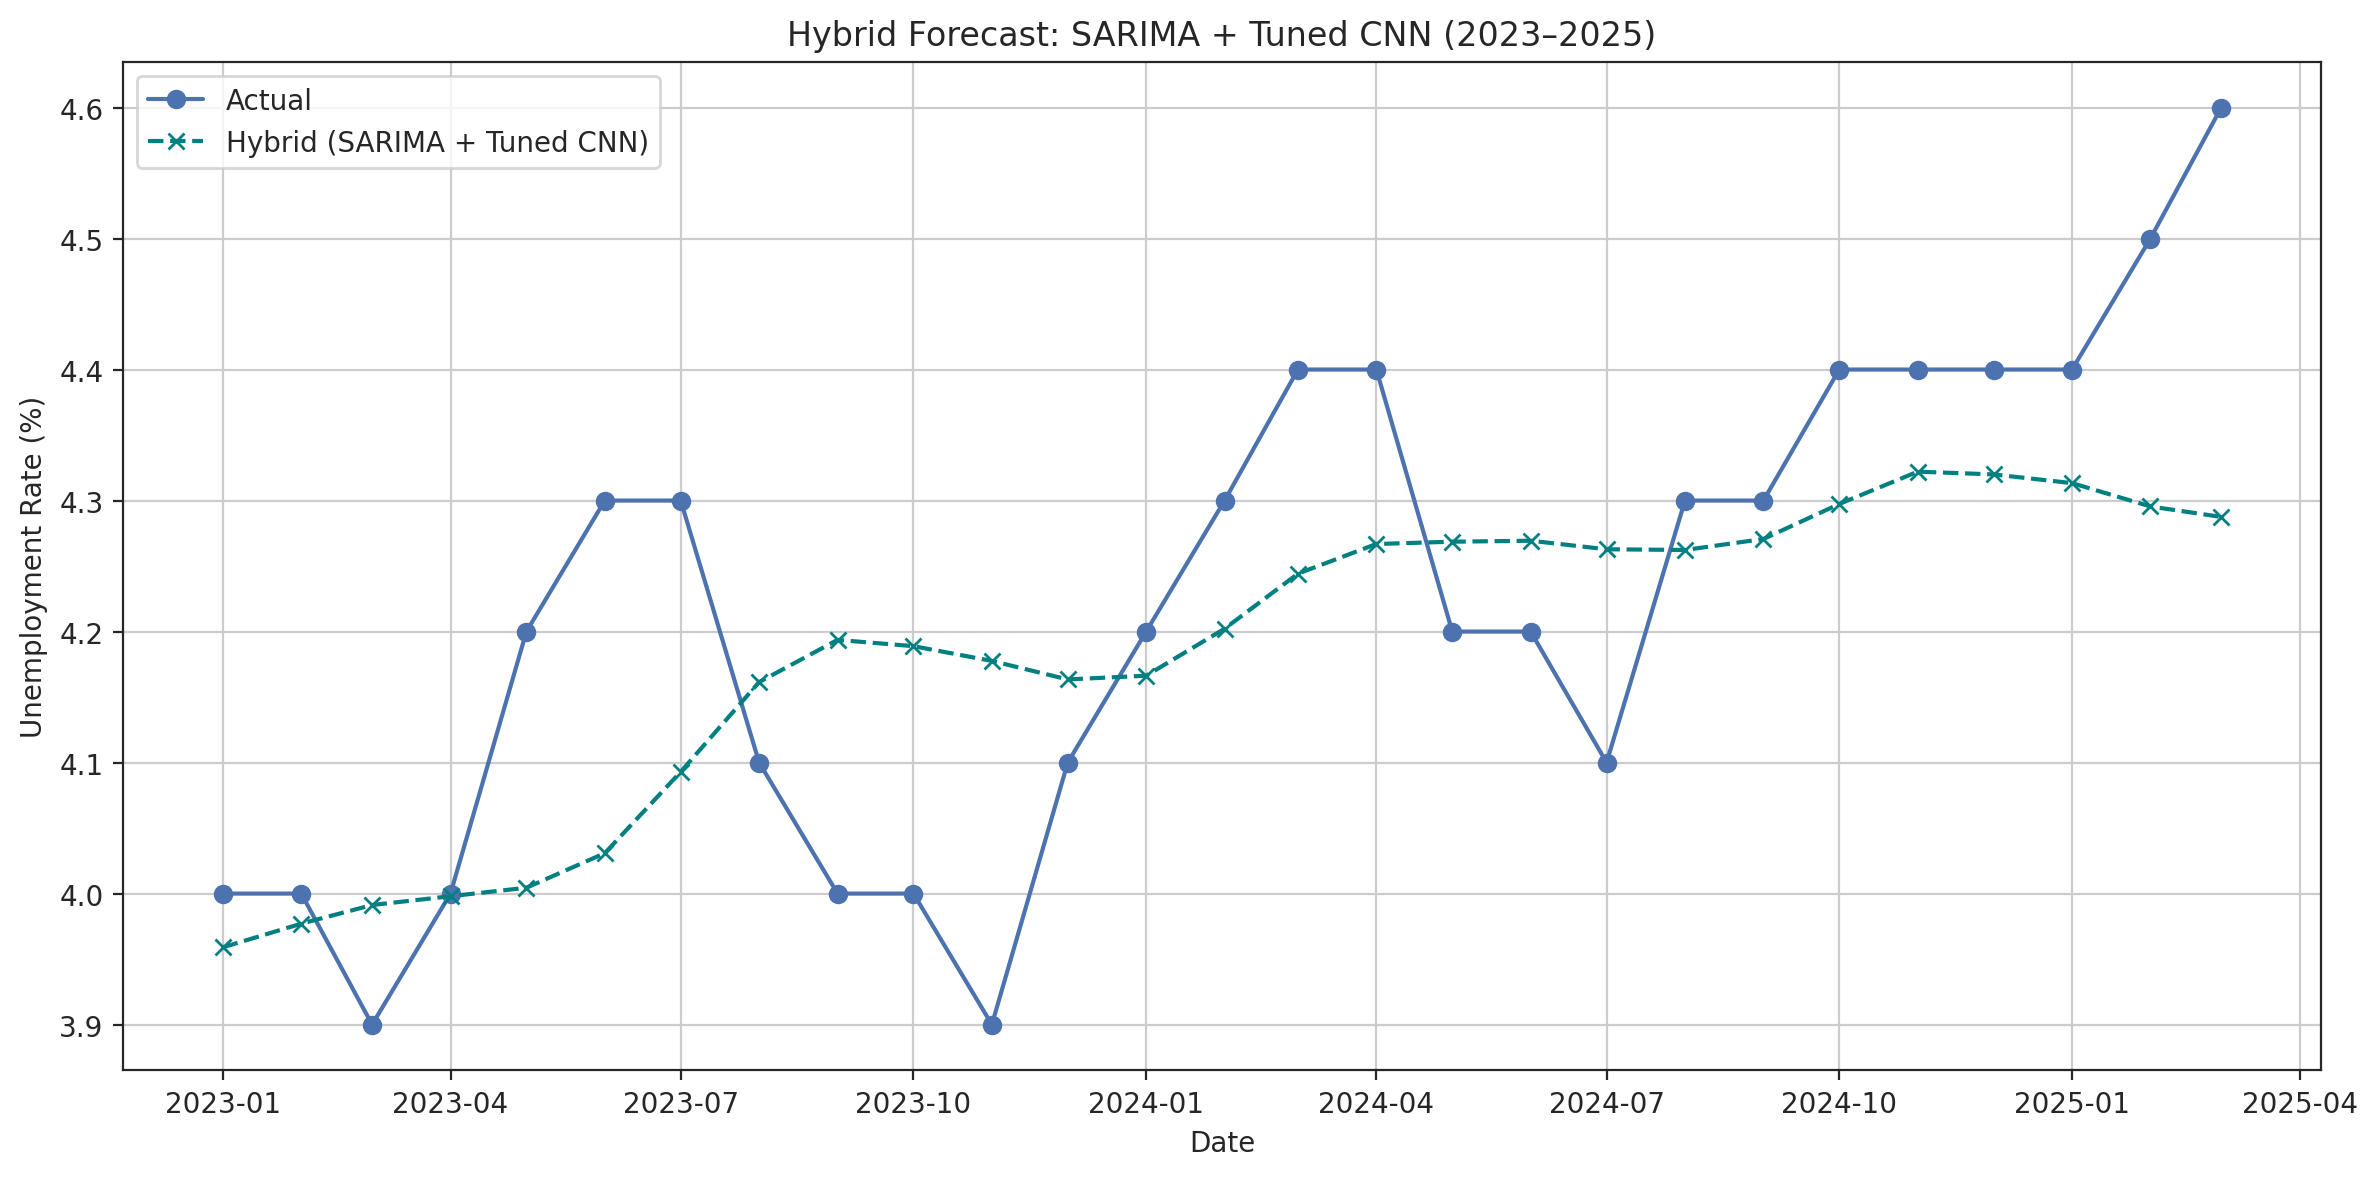

In [ ]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(test_sarima.index, y_test_actual, label='Actual', marker='o')
plt.plot(test_sarima.index, hybrid_cnn, label='Hybrid (SARIMA + Tuned CNN)', linestyle='--', marker='x', color='teal')
plt.title('Hybrid Forecast: SARIMA + Tuned CNN (2023–2025)')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from scipy import stats
import pandas as pd

def diebold_mariano_test(actual, forecast1, forecast2):
    """
    Diebold-Mariano test for forecast accuracy comparison
    """
    # Calculate forecast errors
    error1 = actual - forecast1
    error2 = actual - forecast2

    # Calculate squared errors
    se1 = error1**2
    se2 = error2**2

    # Calculate loss differential
    loss_diff = se1 - se2

    # Calculate mean of loss differential
    d_bar = np.mean(loss_diff)

    # Calculate variance of loss differential
    n = len(loss_diff)
    var_d = np.var(loss_diff, ddof=1)

    # Calculate DM statistic
    dm_stat = d_bar / np.sqrt(var_d / n)

    # Calculate p-value (two-tailed test)
    p_value = 2 * (1 - stats.norm.cdf(abs(dm_stat)))

    return dm_stat, p_value

# Fixed version - remove .values since they're already numpy arrays
actual_unemployment = y_test  # Already numpy array from your ML section
sarima_forecasts = predicted_sarima  # Already numpy array from SARIMA
cnn_forecasts = cnn_pred.flatten()  # CNN predictions (after inverse scaling)
lstm_forecasts = lstm_pred.flatten()  # LSTM predictions (after inverse scaling)
gb_forecasts = gb_pred  # Gradient Boosting predictions
xgb_forecasts = xgb_pred  # XGBoost predictions
rf_forecasts = rf_pred  # Random Forest predictions

# Your hybrid forecasts
hybrid_sarima_cnn = 0.5 * sarima_forecasts + 0.5 * cnn_forecasts

# Key comparisons
comparisons = [
    ("SARIMA", "CNN", sarima_forecasts, cnn_forecasts),
    ("CNN", "LSTM", cnn_forecasts, lstm_forecasts),
    ("SARIMA", "SARIMA+CNN Hybrid", sarima_forecasts, hybrid_sarima_cnn),
    ("SARIMA", "Gradient Boosting", sarima_forecasts, gb_forecasts),
    ("CNN", "SARIMA+CNN Hybrid", cnn_forecasts, hybrid_sarima_cnn),
    ("Gradient Boosting", "CNN", gb_forecasts, cnn_forecasts),
]

print("DIEBOLD-MARIANO TEST RESULTS")
print("=" * 60)
print(f"Sample size: {len(actual_unemployment)} observations")
print("=" * 60)

results = []
for name1, name2, forecast1, forecast2 in comparisons:
    dm_stat, p_val = diebold_mariano_test(actual_unemployment, forecast1, forecast2)

    if p_val < 0.01:
        significance = "***"
    elif p_val < 0.05:
        significance = "**"
    elif p_val < 0.10:
        significance = "*"
    else:
        significance = ""

    better_model = name2 if dm_stat < 0 else name1

    print(f"\n{name1} vs {name2}:")
    print(f"  DM Statistic: {dm_stat:7.3f}")
    print(f"  p-value:      {p_val:7.3f}{significance}")
    print(f"  Significant:  {'Yes' if p_val < 0.05 else 'No'}")

    results.append({
        'Model 1': name1,
        'Model 2': name2,
        'DM Statistic': f'{dm_stat:.3f}',
        'p-value': f'{p_val:.3f}',
        'Significant (5%)': 'Yes' if p_val < 0.05 else 'No'
    })

# Create results table
results_df = pd.DataFrame(results)
print("\n" + "=" * 60)
print("RESULTS TABLE FOR YOUR CHAPTER")
print("=" * 60)
print(results_df.to_string(index=False))

DIEBOLD-MARIANO TEST RESULTS
Sample size: 27 observations

SARIMA vs CNN:
  DM Statistic:  -1.306
  p-value:        0.192
  Significant:  No

CNN vs LSTM:
  DM Statistic:   0.092
  p-value:        0.926
  Significant:  No

SARIMA vs SARIMA+CNN Hybrid:
  DM Statistic:  -1.286
  p-value:        0.198
  Significant:  No

SARIMA vs Gradient Boosting:
  DM Statistic:  -1.889
  p-value:        0.059*
  Significant:  No

CNN vs SARIMA+CNN Hybrid:
  DM Statistic:   1.326
  p-value:        0.185
  Significant:  No

Gradient Boosting vs CNN:
  DM Statistic:   1.277
  p-value:        0.202
  Significant:  No

RESULTS TABLE FOR YOUR CHAPTER
          Model 1           Model 2 DM Statistic p-value Significant (5%)
           SARIMA               CNN       -1.306   0.192               No
              CNN              LSTM        0.092   0.926               No
           SARIMA SARIMA+CNN Hybrid       -1.286   0.198               No
           SARIMA Gradient Boosting       -1.889   0.059           

In [ ]:
import numpy as np
from scipy import stats
import pandas as pd

def diebold_mariano_test(actual, forecast1, forecast2):
    """
    Diebold-Mariano test for forecast accuracy comparison
    """
    error1 = actual - forecast1
    error2 = actual - forecast2

    se1 = error1**2
    se2 = error2**2

    loss_diff = se1 - se2
    d_bar = np.mean(loss_diff)

    n = len(loss_diff)
    var_d = np.var(loss_diff, ddof=1)

    dm_stat = d_bar / np.sqrt(var_d / n)
    p_value = 2 * (1 - stats.norm.cdf(abs(dm_stat)))

    return dm_stat, p_value

# === Forecasts from your notebook ===
actual_unemployment = y_test  # numpy array
sarima_forecasts = predicted_sarima
rf_forecasts = rf_pred
gb_forecasts = gb_pred
xgb_forecasts = xgb_pred
lstm_forecasts = lstm_pred.flatten()
cnn_forecasts = cnn_pred.flatten()

# === Hybrids ===
hybrid_sarima_rf = 0.5 * sarima_forecasts + 0.5 * rf_forecasts
hybrid_sarima_gb = 0.5 * sarima_forecasts + 0.5 * gb_forecasts
hybrid_sarima_xgb = 0.5 * sarima_forecasts + 0.5 * xgb_forecasts
hybrid_sarima_lstm = 0.5 * sarima_forecasts + 0.5 * lstm_forecasts
hybrid_sarima_cnn = 0.5 * sarima_forecasts + 0.5 * cnn_forecasts

# === Build comparisons (all key pairs) ===
comparisons = [
    # Standalone models
    ("SARIMA", "Random Forest", sarima_forecasts, rf_forecasts),
    ("SARIMA", "Gradient Boosting", sarima_forecasts, gb_forecasts),
    ("SARIMA", "XGBoost", sarima_forecasts, xgb_forecasts),
    ("SARIMA", "LSTM", sarima_forecasts, lstm_forecasts),
    ("SARIMA", "CNN", sarima_forecasts, cnn_forecasts),
    ("Random Forest", "Gradient Boosting", rf_forecasts, gb_forecasts),
    ("Random Forest", "XGBoost", rf_forecasts, xgb_forecasts),
    ("Random Forest", "LSTM", rf_forecasts, lstm_forecasts),
    ("Random Forest", "CNN", rf_forecasts, cnn_forecasts),
    ("Gradient Boosting", "XGBoost", gb_forecasts, xgb_forecasts),
    ("Gradient Boosting", "LSTM", gb_forecasts, lstm_forecasts),
    ("Gradient Boosting", "CNN", gb_forecasts, cnn_forecasts),
    ("XGBoost", "LSTM", xgb_forecasts, lstm_forecasts),
    ("XGBoost", "CNN", xgb_forecasts, cnn_forecasts),
    ("LSTM", "CNN", lstm_forecasts, cnn_forecasts),

    # Hybrids vs SARIMA
    ("SARIMA", "SARIMA+RF", sarima_forecasts, hybrid_sarima_rf),
    ("SARIMA", "SARIMA+GB", sarima_forecasts, hybrid_sarima_gb),
    ("SARIMA", "SARIMA+XGB", sarima_forecasts, hybrid_sarima_xgb),
    ("SARIMA", "SARIMA+LSTM", sarima_forecasts, hybrid_sarima_lstm),
    ("SARIMA", "SARIMA+CNN", sarima_forecasts, hybrid_sarima_cnn),

    # Hybrids vs their ML/DL counterpart
    ("Random Forest", "SARIMA+RF", rf_forecasts, hybrid_sarima_rf),
    ("Gradient Boosting", "SARIMA+GB", gb_forecasts, hybrid_sarima_gb),
    ("XGBoost", "SARIMA+XGB", xgb_forecasts, hybrid_sarima_xgb),
    ("LSTM", "SARIMA+LSTM", lstm_forecasts, hybrid_sarima_lstm),
    ("CNN", "SARIMA+CNN", cnn_forecasts, hybrid_sarima_cnn),
]

# === Run tests ===
print("DIEBOLD-MARIANO TEST RESULTS")
print("=" * 60)
print(f"Sample size: {len(actual_unemployment)} observations")
print("=" * 60)

results = []
for name1, name2, forecast1, forecast2 in comparisons:
    dm_stat, p_val = diebold_mariano_test(actual_unemployment, forecast1, forecast2)

    if p_val < 0.01:
        significance = "***"
    elif p_val < 0.05:
        significance = "**"
    elif p_val < 0.10:
        significance = "*"
    else:
        significance = ""

    better_model = name2 if dm_stat < 0 else name1

    print(f"\n{name1} vs {name2}:")
    print(f"  DM Statistic: {dm_stat:7.3f}")
    print(f"  p-value:      {p_val:7.3f}{significance}")
    print(f"  Significant:  {'Yes' if p_val < 0.05 else 'No'}")

    results.append({
        'Model 1': name1,
        'Model 2': name2,
        'DM Statistic': f'{dm_stat:.3f}',
        'p-value': f'{p_val:.3f}',
        'Significant (5%)': 'Yes' if p_val < 0.05 else 'No'
    })

# === Results table ===
results_df = pd.DataFrame(results)
print("\n" + "=" * 60)
print("RESULTS TABLE FOR YOUR CHAPTER")
print("=" * 60)
print(results_df.to_string(index=False))


DIEBOLD-MARIANO TEST RESULTS
Sample size: 27 observations

SARIMA vs Random Forest:
  DM Statistic:  -1.541
  p-value:        0.123
  Significant:  No

SARIMA vs Gradient Boosting:
  DM Statistic:  -1.889
  p-value:        0.059*
  Significant:  No

SARIMA vs XGBoost:
  DM Statistic:  -0.324
  p-value:        0.746
  Significant:  No

SARIMA vs LSTM:
  DM Statistic:  -0.794
  p-value:        0.427
  Significant:  No

SARIMA vs CNN:
  DM Statistic:  -1.306
  p-value:        0.192
  Significant:  No

Random Forest vs Gradient Boosting:
  DM Statistic:  -0.362
  p-value:        0.717
  Significant:  No

Random Forest vs XGBoost:
  DM Statistic:   2.729
  p-value:        0.006***
  Significant:  Yes

Random Forest vs LSTM:
  DM Statistic:   0.887
  p-value:        0.375
  Significant:  No

Random Forest vs CNN:
  DM Statistic:   1.031
  p-value:        0.303
  Significant:  No

Gradient Boosting vs XGBoost:
  DM Statistic:   4.590
  p-value:        0.000***
  Significant:  Yes

Gradient Bo

In [ ]:
# Diebold-Mariano Test
def diebold_mariano_test(actual, forecast1, forecast2, h=1, crit="MSE"):
    """
    Diebold-Mariano test with Newey-West variance correction.
    """
    e1 = actual - forecast1
    e2 = actual - forecast2

    if crit == "MSE":
        d = (e1**2) - (e2**2)
    elif crit == "MAE":
        d = np.abs(e1) - np.abs(e2)
    else:
        raise ValueError("crit must be 'MSE' or 'MAE'")

    d_mean = np.mean(d)
    n = len(d)

    # Newey-West HAC variance estimator
    gamma = []
    for lag in range(1, h):
        cov = np.cov(d[lag:], d[:-lag], ddof=1)[0, 1]
        gamma.append((1 - lag/h) * cov)
    var_d = np.var(d, ddof=1) + 2 * np.sum(gamma)

    dm_stat = d_mean / np.sqrt(var_d / n)
    p_value = 2 * (1 - norm.cdf(abs(dm_stat)))
    return dm_stat, p_value


#Collect all forecasts
models = {
    "SARIMA": sarima_forecasts,
    "Random Forest": rf_pred,
    "Gradient Boosting": gb_pred,
    "XGBoost": xgb_pred,
    "LSTM": lstm_pred.flatten(),
    "CNN": cnn_pred.flatten(),
    "SARIMA+RF": 0.5 * sarima_forecasts + 0.5 * rf_pred,
    "SARIMA+GB": 0.5 * sarima_forecasts + 0.5 * gb_pred,
    "SARIMA+XGB": 0.5 * sarima_forecasts + 0.5 * xgb_pred,
    "SARIMA+LSTM": 0.5 * sarima_forecasts + 0.5 * lstm_pred.flatten(),
    "SARIMA+CNN": 0.5 * sarima_forecasts + 0.5 * cnn_pred.flatten()
}

#Run all pairwise comparisons
results = []
names = list(models.keys())

for i in range(len(names)):
    for j in range(i+1, len(names)):
        name1, name2 = names[i], names[j]
        f1, f2 = models[name1], models[name2]

        dm_stat, p_val = diebold_mariano_test(actual_unemployment, f1, f2, h=1, crit="MSE")

        if p_val < 0.01:
            sig = "***"
        elif p_val < 0.05:
            sig = "**"
        elif p_val < 0.10:
            sig = "*"
        else:
            sig = ""

        results.append({
            "Model 1": name1,
            "Model 2": name2,
            "DM Statistic": round(dm_stat, 3),
            "p-value": round(p_val, 3),
            "Significant (5%)": "Yes" if p_val < 0.05 else "No",
            "Stars": sig
        })

#Results Table
results_df = pd.DataFrame(results)
print("DIEBOLD-MARIANO TEST RESULTS")
print("="*60)
print(f"Sample size: {len(actual_unemployment)} observations")
print("="*60)
print(results_df.to_string(index=False))


DIEBOLD-MARIANO TEST RESULTS
Sample size: 27 observations
          Model 1           Model 2  DM Statistic  p-value Significant (5%) Stars
           SARIMA     Random Forest        -1.541    0.123               No      
           SARIMA Gradient Boosting        -1.889    0.059               No     *
           SARIMA           XGBoost        -0.324    0.746               No      
           SARIMA              LSTM        -0.794    0.427               No      
           SARIMA               CNN        -1.306    0.192               No      
           SARIMA         SARIMA+RF        -1.500    0.134               No      
           SARIMA         SARIMA+GB        -1.855    0.064               No     *
           SARIMA        SARIMA+XGB        -0.281    0.778               No      
           SARIMA       SARIMA+LSTM        -0.763    0.445               No      
           SARIMA        SARIMA+CNN        -1.286    0.198               No      
    Random Forest Gradient Boosting     

## Forecasting till 2030

In [ ]:
#Refit SARIMA on full dataset (Feb 1971 - Mar 2025)
final_sarima = SARIMAX(mdata['Unemployment'], order=(2,1,1), seasonal_order=(2,1,1,12))
final_sarima_fitted = final_sarima.fit()

#Forecast SARIMA to 2030
future_periods = 69  # Apr 2025 - Dec 2030
sarima_forecast_2030 = final_sarima_fitted.get_forecast(steps=future_periods)
sarima_pred_2030 = sarima_forecast_2030.predicted_mean

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
#Get the last 12 unemployment values as numpy array
last_12_values = np.array(mdata['Unemployment'].iloc[-12:])

#Scale them properly
last_12_scaled = scaler.transform(last_12_values.reshape(-1, 1))
last_12_scaled = np.array(last_12_scaled).flatten()  # Force to numpy array

print("Shape check:", last_12_scaled.shape)
print("Type check:", type(last_12_scaled))

# Simple CNN forecasting function
def forecast_cnn_to_2030(model, scaler, initial_sequence, n_periods):
    predictions = []
    current_seq = np.array(initial_sequence)

    for i in range(n_periods):
        #Reshape for CNN prediction
        X_input = current_seq.reshape(1, 12, 1)

        #Get prediction (scaled)
        pred_scaled = model.predict(X_input, verbose=0)[0, 0]

        #Convert to actual unemployment rate
        pred_actual = scaler.inverse_transform(np.array([[pred_scaled]]))[0, 0]
        predictions.append(pred_actual)

        #Update sequence - shift left and add new prediction
        current_seq = np.roll(current_seq, -1)
        current_seq[-1] = pred_scaled

        if i % 10 == 0:
            print(f"Forecasted {i+1}/{n_periods} periods")

    return np.array(predictions)

#Generate CNN forecasts
print("Generating CNN forecasts to 2030...")
cnn_2030_forecasts = forecast_cnn_to_2030(cnn_model, scaler, last_12_scaled, 69)

#Generate SARIMA forecasts
print("Generating SARIMA forecasts to 2030...")
sarima_model_full = SARIMAX(mdata['Unemployment'], order=(2,1,1), seasonal_order=(2,1,1,12))
sarima_fitted_full = sarima_model_full.fit(disp=False)
sarima_2030_forecasts = sarima_fitted_full.get_forecast(steps=69).predicted_mean

#Create hybrid forecast
hybrid_2030_forecasts = 0.5 * np.array(sarima_2030_forecasts) + 0.5 * cnn_2030_forecasts

#Display results
print(f"\nForecast Results:")
print(f"December 2030: {hybrid_2030_forecasts[-1]:.2f}%")
print(f"Average 2025-2030: {np.mean(hybrid_2030_forecasts):.2f}%")

Shape check: (12,)
Type check: <class 'numpy.ndarray'>
Generating CNN forecasts to 2030...


Forecasted 1/69 periods
Forecasted 11/69 periods
Forecasted 21/69 periods
Forecasted 31/69 periods
Forecasted 41/69 periods
Forecasted 51/69 periods
Forecasted 61/69 periods
Generating SARIMA forecasts to 2030...


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




Forecast Results:
December 2030: 4.86%
Average 2025-2030: 4.76%


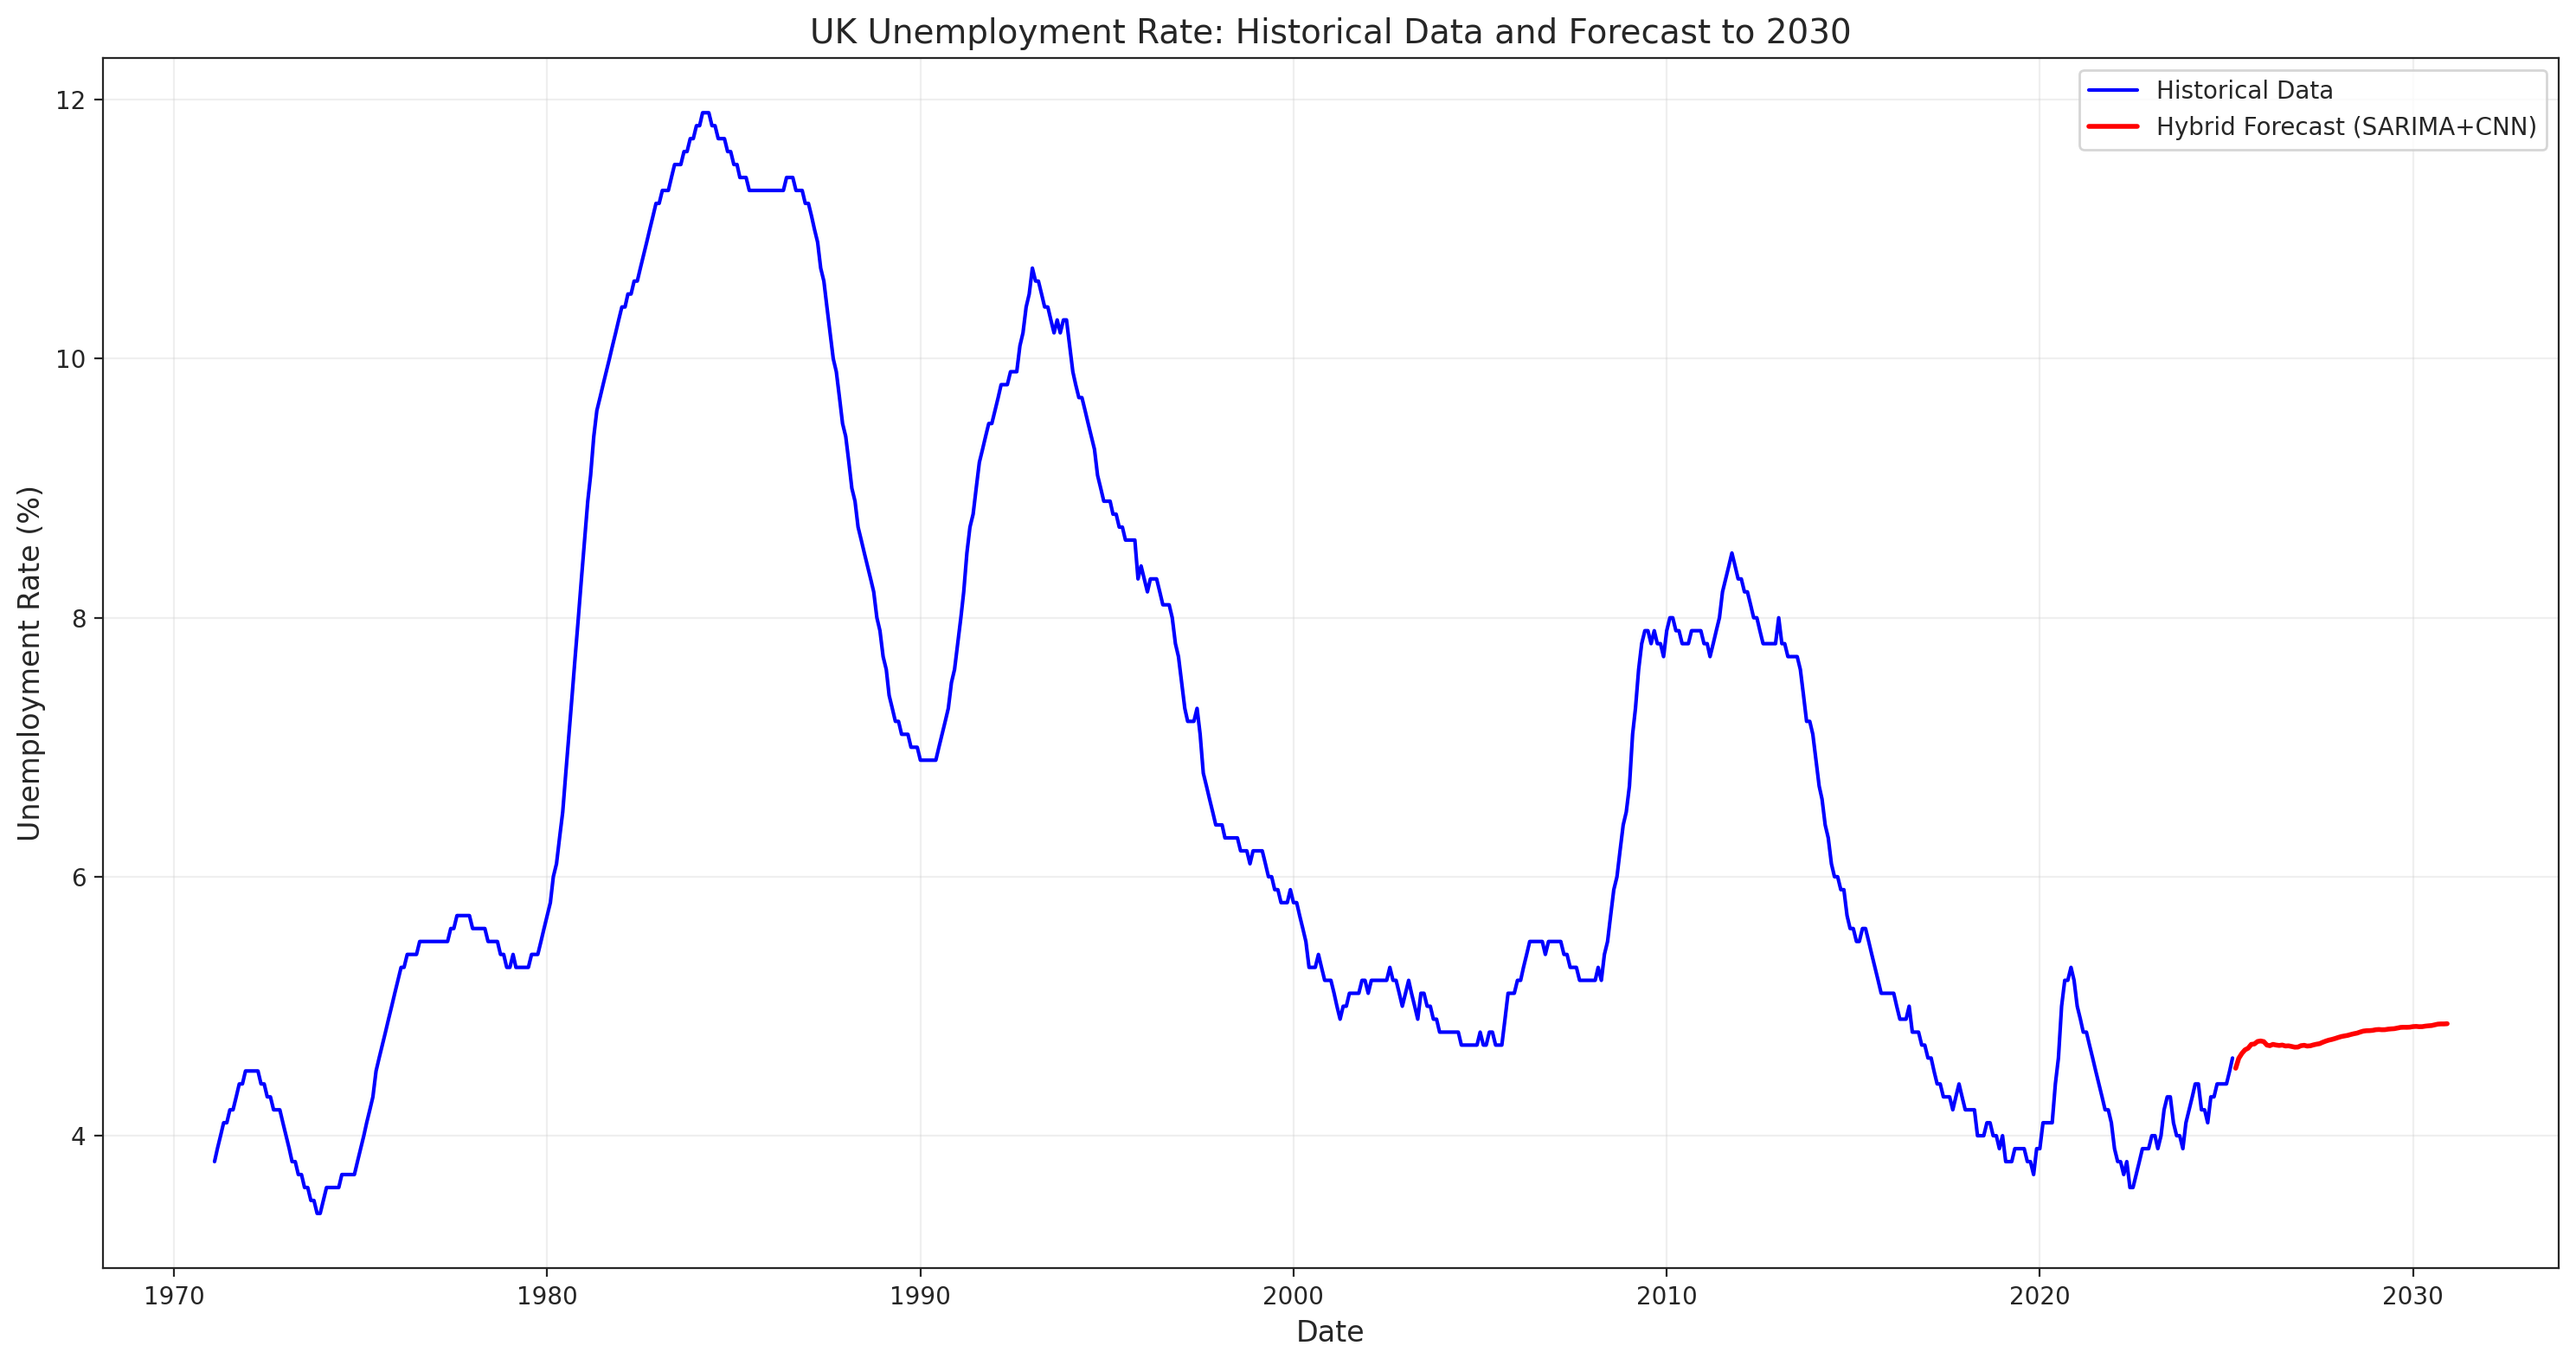


Key Forecast Values:
April 2025: 4.52%
December 2025: 4.73%
December 2026: 4.68%
December 2027: 4.75%
December 2028: 4.81%
December 2029: 4.84%
December 2030: 4.86%


In [ ]:
#Create the plot
plt.figure(figsize=(15, 8))

#Plot historical data
plt.plot(mdata.index, mdata['Unemployment'], label='Historical Data', color='blue', linewidth=1.5)

#Create future dates for plotting
future_dates = pd.date_range(start='2025-04-01', periods=69, freq='MS')

#Plot forecast
plt.plot(future_dates, hybrid_2030_forecasts, label='Hybrid Forecast (SARIMA+CNN)', color='red', linewidth=2)

#Formatting
plt.title('UK Unemployment Rate: Historical Data and Forecast to 2030', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Unemployment Rate (%)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#Print key forecast values
print(f"\nKey Forecast Values:")
print(f"April 2025: {hybrid_2030_forecasts[0]:.2f}%")
print(f"December 2025: {hybrid_2030_forecasts[8]:.2f}%")
print(f"December 2026: {hybrid_2030_forecasts[20]:.2f}%")
print(f"December 2027: {hybrid_2030_forecasts[32]:.2f}%")
print(f"December 2028: {hybrid_2030_forecasts[44]:.2f}%")
print(f"December 2029: {hybrid_2030_forecasts[56]:.2f}%")
print(f"December 2030: {hybrid_2030_forecasts[68]:.2f}%")

In [ ]:
forecast_df = pd.DataFrame(forecast_summary)
print(forecast_df.to_string(index=False))

                Model Final Value (Dec 2030) Average (2025-2030) Range (Min-Max)
               SARIMA                  5.67%               5.40%   4.65% - 5.67%
                  CNN                  4.06%               4.12%   4.00% - 4.49%
Hybrid (SARIMA + CNN)                  4.86%               4.76%   4.52% - 4.86%


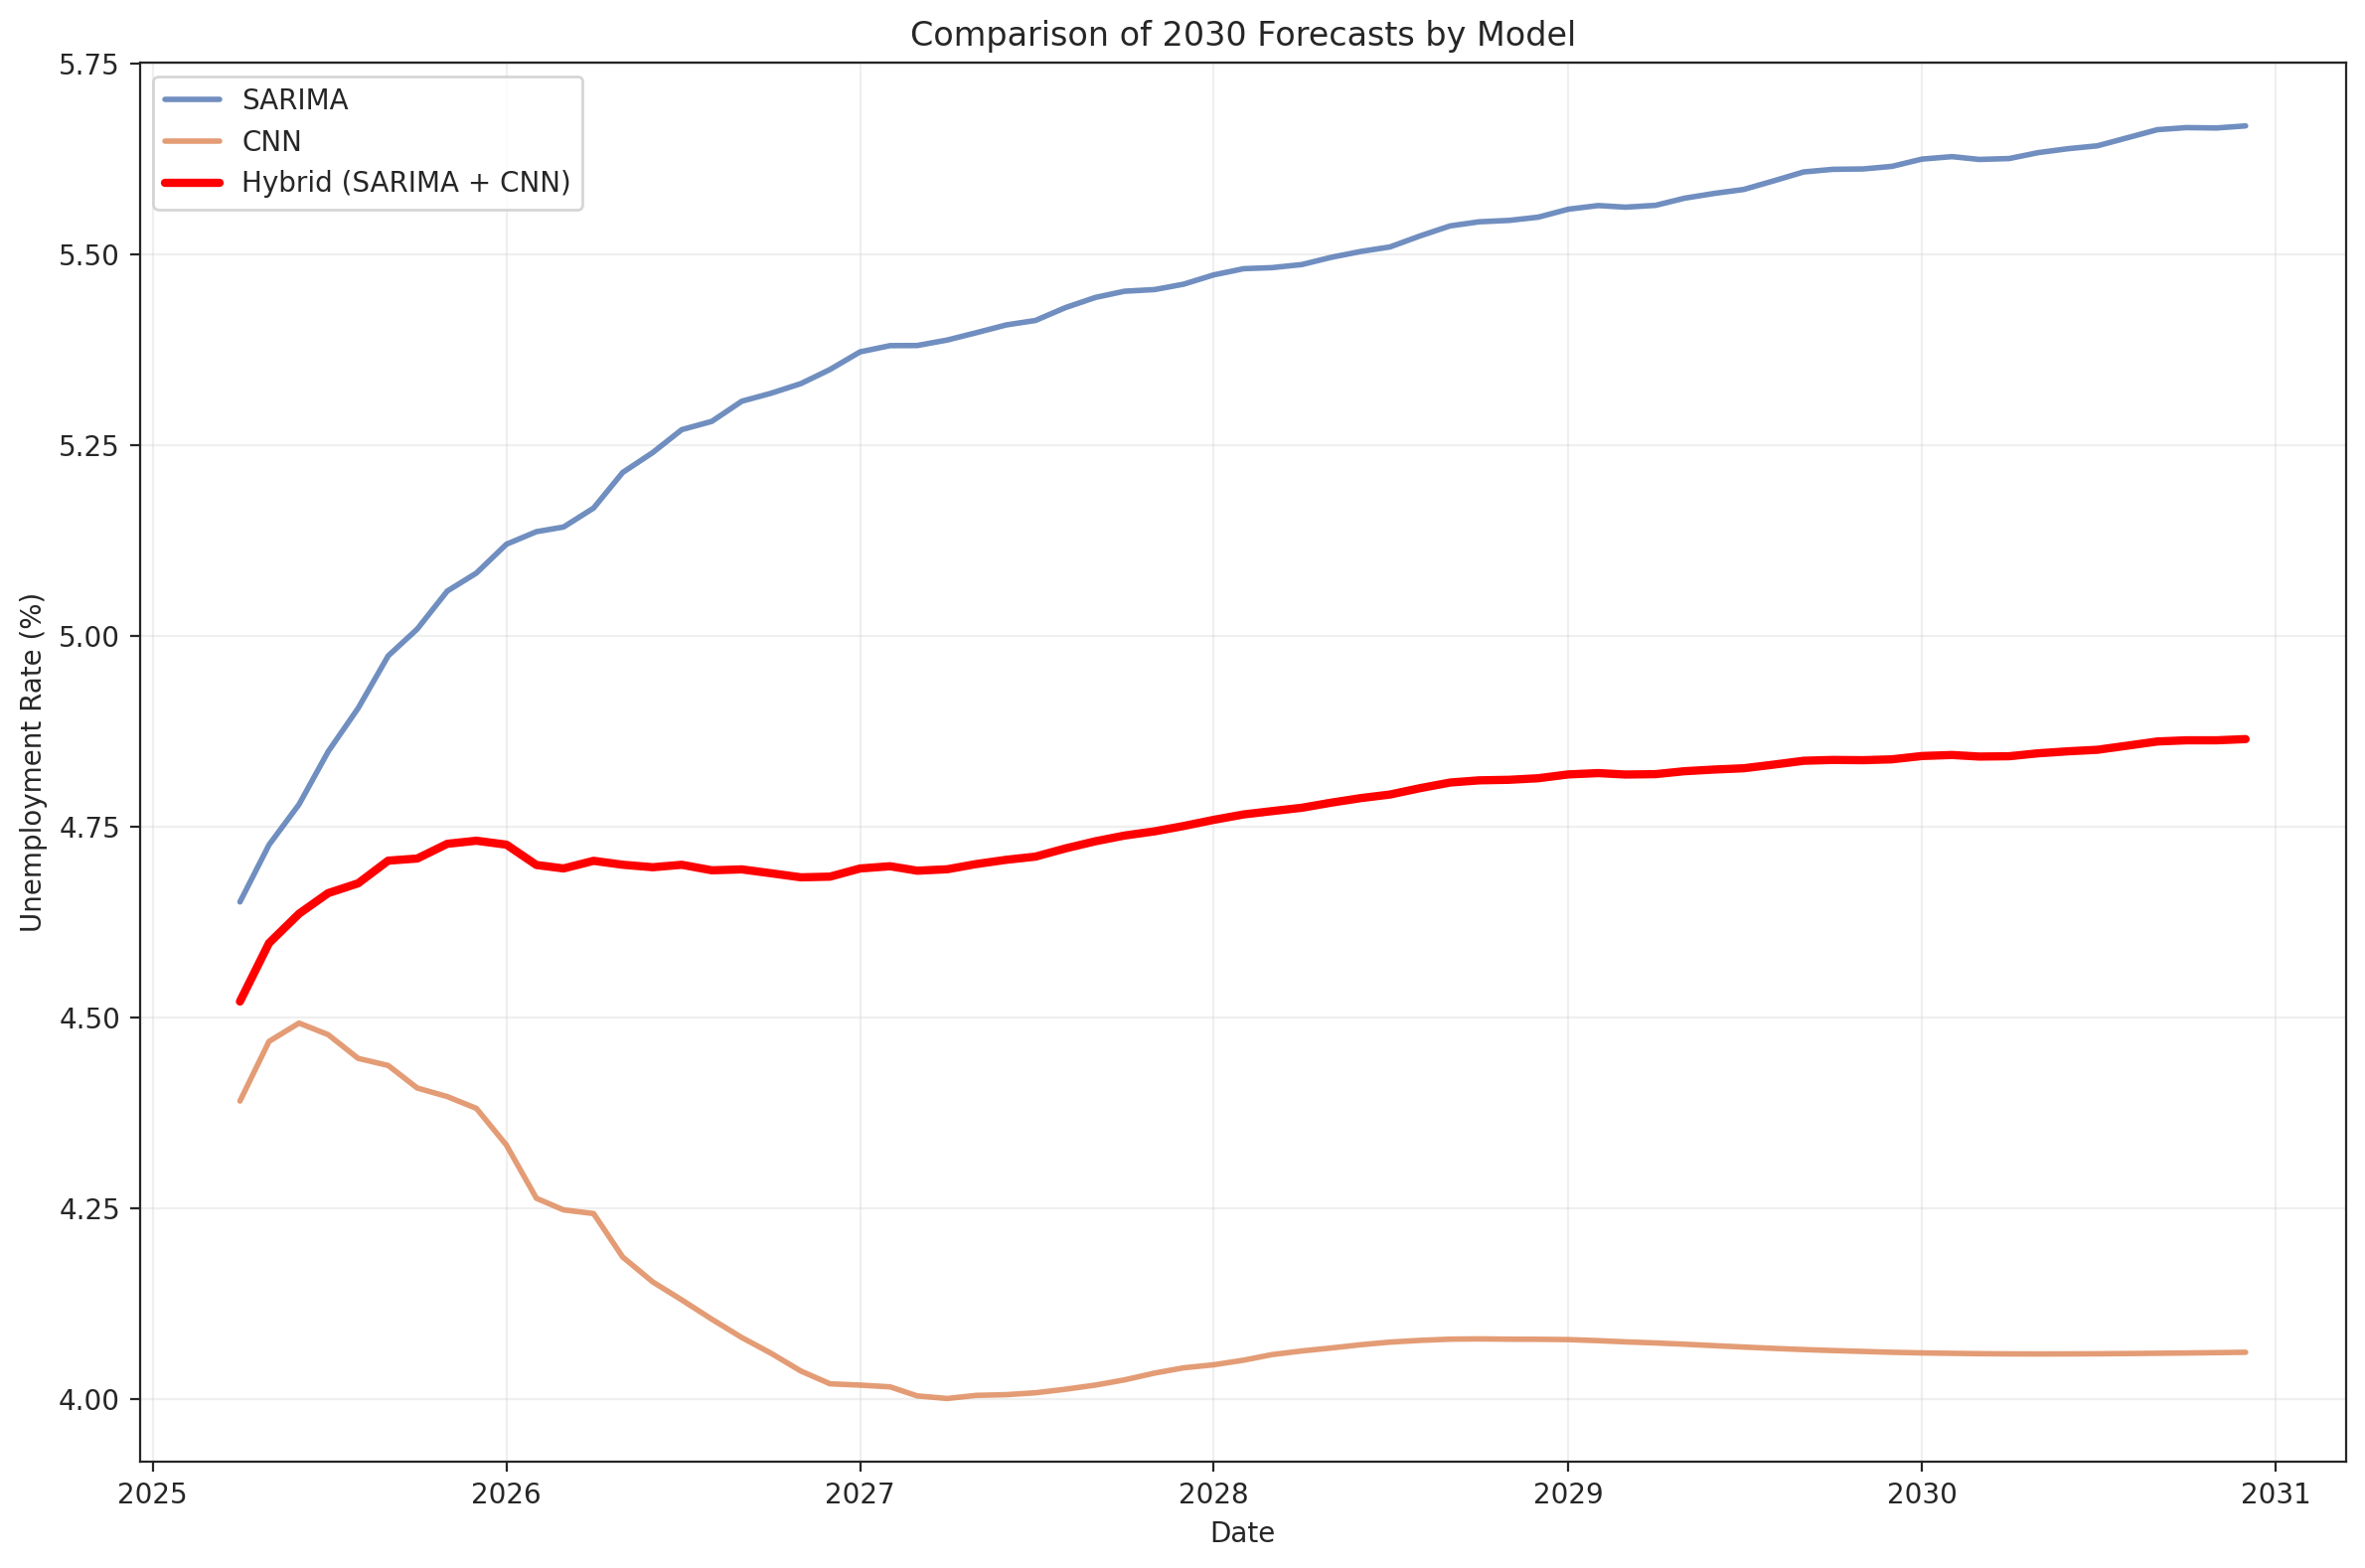

In [ ]:
#create a comparison plot
plt.figure(figsize=(12, 8))
plt.plot(future_dates, sarima_2030_forecasts, label='SARIMA', linewidth=2, alpha=0.8)
plt.plot(future_dates, cnn_2030_forecasts, label='CNN', linewidth=2, alpha=0.8)
plt.plot(future_dates, hybrid_2030_forecasts, label='Hybrid (SARIMA + CNN)', linewidth=3, color='red')
plt.title('Comparison of 2030 Forecasts by Model')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
#Calculate metrics for 2030 forecasts
print("2030 FORECAST SUMMARY METRICS")

#Create summary table
forecast_summary = {
    'Model': ['SARIMA', 'CNN', 'Hybrid (SARIMA + CNN)'],
    'Final Value (Dec 2030)': [
        f"{sarima_2030_forecasts[-1]:.2f}%",
        f"{cnn_2030_forecasts[-1]:.2f}%",
        f"{hybrid_2030_forecasts[-1]:.2f}%"
    ],
    'Average (2025-2030)': [
        f"{np.mean(sarima_2030_forecasts):.2f}%",
        f"{np.mean(cnn_2030_forecasts):.2f}%",
        f"{np.mean(hybrid_2030_forecasts):.2f}%"
    ],
    'Range (Min-Max)': [
        f"{np.min(sarima_2030_forecasts):.2f}% - {np.max(sarima_2030_forecasts):.2f}%",
        f"{np.min(cnn_2030_forecasts):.2f}% - {np.max(cnn_2030_forecasts):.2f}%",
        f"{np.min(hybrid_2030_forecasts):.2f}% - {np.max(hybrid_2030_forecasts):.2f}%"
    ]
}

2030 FORECAST SUMMARY METRICS
